Förklaring från Alexei om val av att ha json i snowflake:

Grejen är att metering_point och meter_reading data kan uppdateras i efterhand. T.ex. det finns c1-c5 koefficienterna som kan tillkomma, väderdata, standardavvikelse på mätningen, etc. Problemet är att detta kan hända rätt ofta i fortsättningen och update operationen är tidskrävande. Samtidigt kan datamodellen ändras, osannolikt men möjligt. Då skulle man behöva designa om tabellerna. Därför valde vi att lagra allt data som kommer istället och skapa endast de viktigaste kolumnerna som behövs för att skapa views. Du kan fortfarande köra queries mot json som om det vore SQL. Det är fördelen med snowflake - https://docs.snowflake.com/en/user-guide/querying-semistructured.html

Hämta all öresundskraft data för property=energi, formattera med rätt dataformat direkt i sql

In [89]:
import pyodbc

#Using connection string to connect to the datalake
connection = pyodbc.connect("Driver={SnowflakeDSIIDriver}; Server=lq42418.eu-west-1.snowflakecomputing.com; Database=SMARTENERGI_DATALAKE; schema=public; UID=smartenergi_public_user; PWD=SmartEnergi2020!")
cus=connection.cursor()

#Executing the query on meter readings view
cus.execute("use warehouse compute_wh;")
select_stmt = """WITH energy_by_day as
(SELECT date(SRC:timestamp::datetime) as timestamp, SRC:metering_point_id::string as metering_point_id, sum(SRC:value::integer) as value, SRC:unit_of_measure::string as unit_of_measure
FROM "SMARTENERGI_DATALAKE"."PUBLIC"."METER_READINGS" 
WHERE PROPERTY = 'energy' and SRC:source_instance_name like '%oresundskraft%'
group by date(SRC:timestamp::datetime), SRC:metering_point_id, SRC:unit_of_measure), 

 days_per_station as
(select metering_point_id, min(timestamp), max(timestamp), count(*) as N
from energy_by_day
group by metering_point_id
order by count(*) desc)

select e.* 
from energy_by_day e
inner join (select metering_point_id
from days_per_station
where N>=1638) m on e.metering_point_id = m.metering_point_id
"""
       
select_stmt2 = """WITH energy_by_day as
(SELECT date(SRC:timestamp::datetime) as timestamp, SRC:metering_point_id::string as metering_point_id, sum(SRC:value::integer) as value, SRC:unit_of_measure::string as unit_of_measure
FROM "SMARTENERGI_DATALAKE"."PUBLIC"."METER_READINGS" 
WHERE PROPERTY = 'energy' and SRC:source_instance_name like '%oresundskraft%'
group by date(SRC:timestamp::datetime), SRC:metering_point_id, SRC:unit_of_measure), 

 days_per_station as
(select metering_point_id, min(timestamp), max(timestamp), count(*) as N
from energy_by_day
group by metering_point_id
order by count(*) desc)

select metering_point_id
from days_per_station
where N>=1638
limit 100"""
cus.execute(select_stmt)


Hämta data

In [ ]:
data = cus.fetchall()

Hämta direkt som pandas data frame

In [90]:
import pandas as pd
df = pd.read_sql(select_stmt,connection)


In [91]:
df.head()

TIMESTAMP                     METERING_POINT_ID  VALUE UNIT_OF_MEASURE
0  2015-08-25  5913b86c-7184-11ea-ae00-062fc13530dc   27.0             MWh
1  2015-09-11  5913b86c-7184-11ea-ae00-062fc13530dc   77.0             MWh
2  2015-09-19  5913b86c-7184-11ea-ae00-062fc13530dc   77.0             MWh
3  2015-10-02  5913b86c-7184-11ea-ae00-062fc13530dc  100.0             MWh
4  2015-08-30  5913b86c-7184-11ea-ae00-062fc13530dc   30.0             MWh

In [156]:
ids=df.METERING_POINT_ID.unique()

In [166]:
df['VALUE_NORM'] = df.groupby('METERING_POINT_ID')['VALUE'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

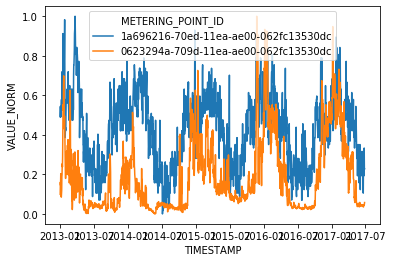

In [37]:
import seaborn as sns
import numpy as np

df_g1 = df[df['METERING_POINT_ID'].isin(ids[:2])]
sns.lineplot(x='TIMESTAMP', y='VALUE_NORM', hue='METERING_POINT_ID', data=df_g1)

In [92]:
df.shape

(3891888, 4)

In [201]:
 df_wide = df.pivot(index='TIMESTAMP',columns='METERING_POINT_ID', values = 'VALUE')

In [94]:
df_wide.shape

(1638, 2376)

In [61]:
#df_wide.iloc[:,1:10].transpose().values.tolist()

In [211]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

seed = 0
np.random.seed(seed)

X_train = TimeSeriesScalerMeanVariance().fit_transform(df_wide.transpose().values.tolist())


In [212]:
X_train_orig = X_train

In [96]:
X_train.shape

(2376, 1638, 1)

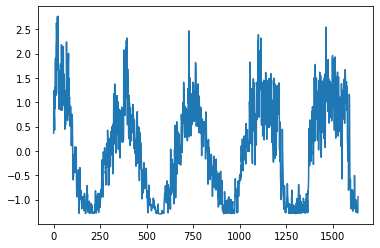

In [97]:
import matplotlib.pyplot as plt
plt.plot(X_train[0])

In [98]:
# Make time series shorter
X_train = TimeSeriesResampler(sz=100).fit_transform(X_train)
#X_train.shape
#plt.plot(X_train[0])
sz = X_train.shape[1]

In [107]:
np.isin(y_pred, [9,3])

array([False, False,  True, ..., False, False,  True])

Ta bort kluster 3,5,6,7

In [138]:
X_train_cleaned = X_train[~np.isin(y_pred, [2,4,5,6])]
X_train_cleaned.shape

(2282, 100, 1)

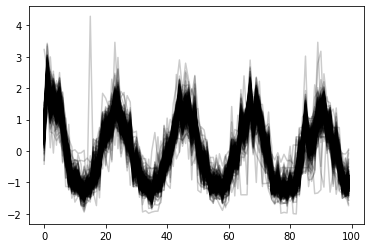

In [136]:
for xx in X_train[y_pred==1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)

In [144]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 66, 868,  91, 312,   1,   1,   1, 101, 128, 807], dtype=int64))

Euclidean k-means
8.267 --> 6.660 --> 6.475 --> 6.409 --> 6.376 --> 6.359 --> 6.350 --> 6.343 --> 6.337 --> 6.332 --> 6.325 --> 6.320 --> 6.315 --> 6.311 --> 6.303 --> 6.297 --> 6.293 --> 6.285 --> 6.275 --> 6.272 --> 6.271 --> 6.270 --> 6.270 --> 6.269 --> 6.269 --> 6.268 --> 6.268 --> 6.268 --> 6.268 --> 6.268 --> 6.268 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 


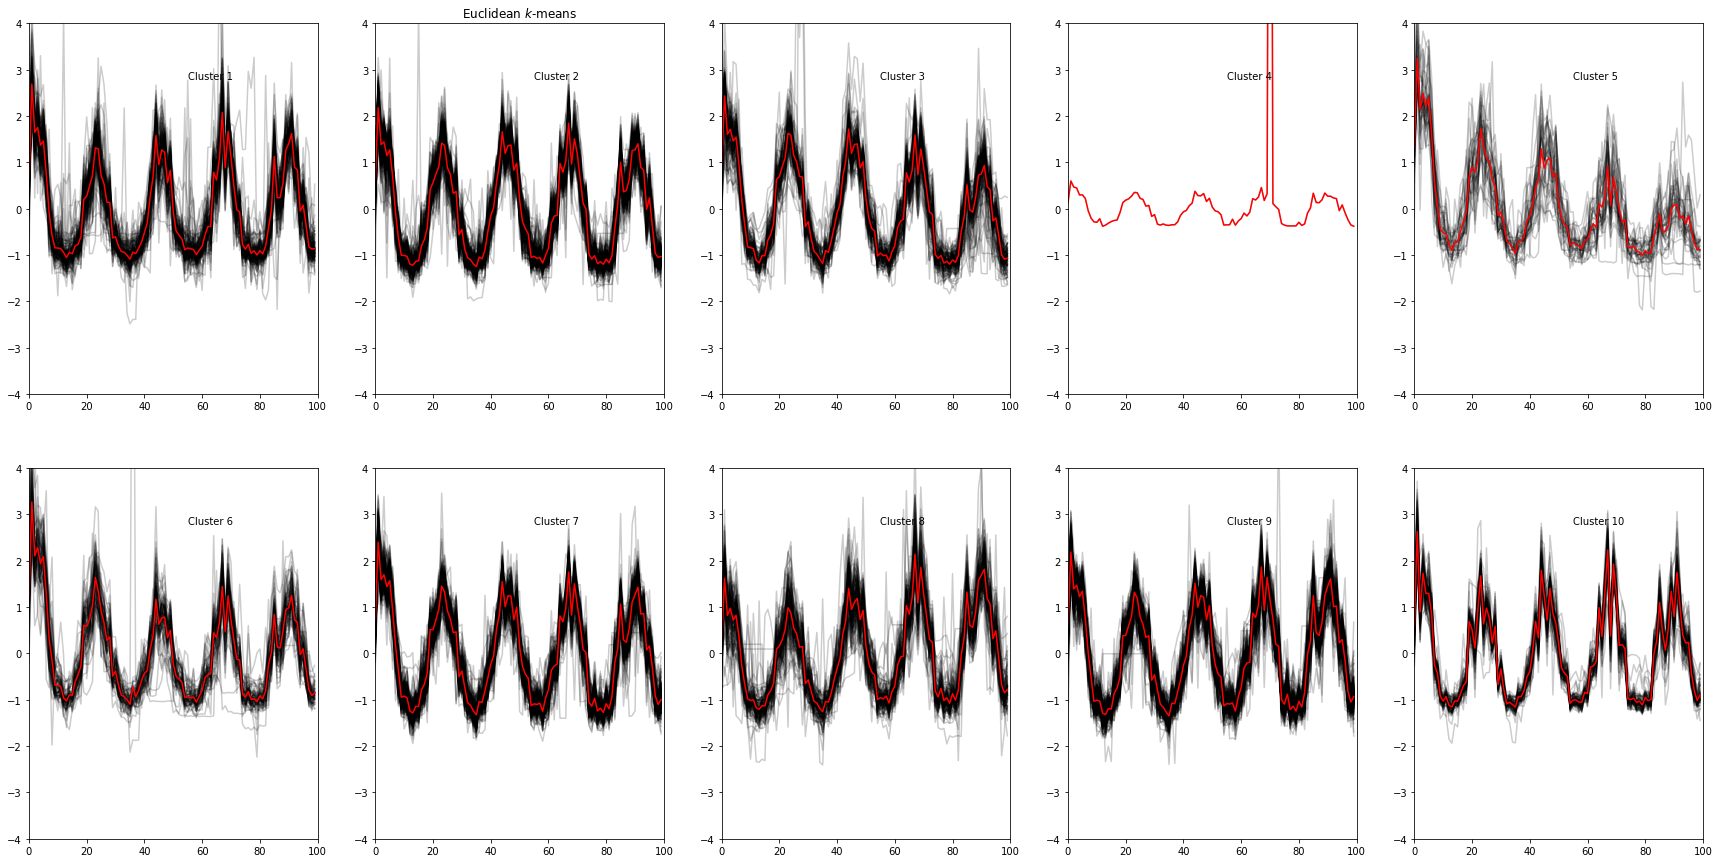

In [139]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=10, verbose=True, random_state=seed)
y_pred2 = km.fit_predict(X_train_cleaned)

plt.figure(figsize=(30,15))
for yi in range(10):
    plt.subplot(2, 5, yi + 1)
    for xx in X_train_cleaned[y_pred2 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [141]:
np.unique(y_pred2, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([145, 438, 122,   1,  31,  66, 641, 118, 639,  81], dtype=int64))

(2184, 100, 1)
7.513 --> 6.294 --> 6.116 --> 6.054 --> 6.028 --> 6.019 --> 6.013 --> 6.008 --> 6.005 --> 6.002 --> 6.001 --> 6.000 --> 5.999 --> 5.999 --> 5.998 --> 5.998 --> 5.997 --> 5.997 --> 5.997 --> 5.997 --> 5.997 --> 


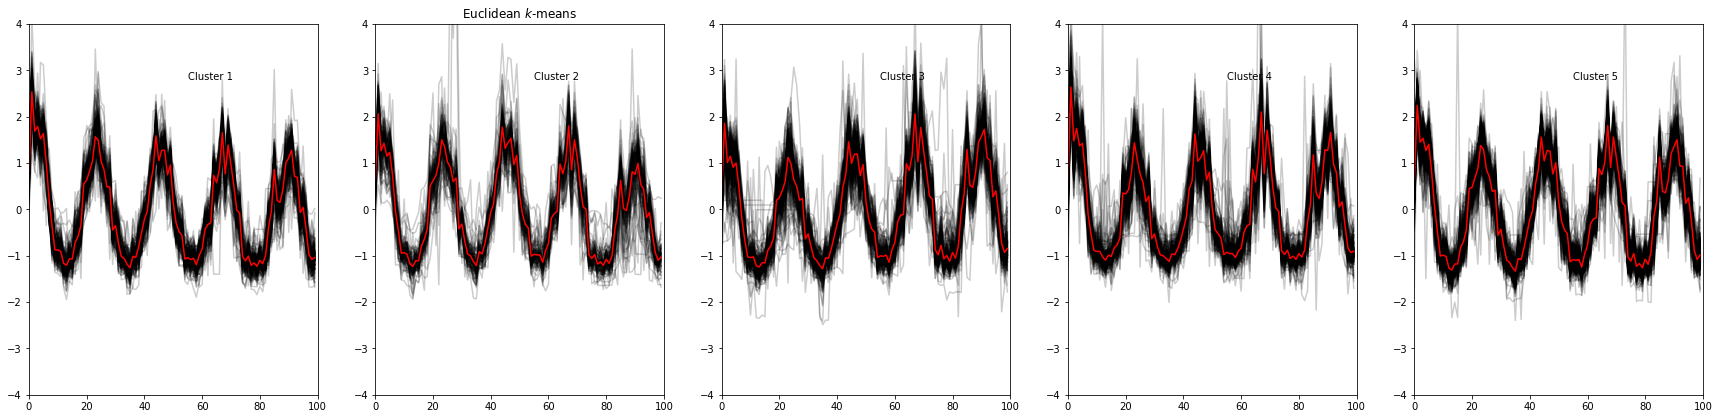

In [143]:
X_train_cleaned2 = X_train_cleaned[~np.isin(y_pred2, [3, 4, 5])]
print(X_train_cleaned2.shape)
km = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=seed)
y_pred3 = km.fit_predict(X_train_cleaned2)

plt.figure(figsize=(30,15))
for yi in range(5):
    plt.subplot(2, 5, yi + 1)
    for xx in X_train_cleaned2[y_pred3 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

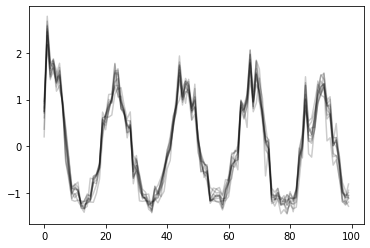

In [152]:
group2=X_train[y_pred==1]
for xx in group2[20:30]:
        plt.plot(xx.ravel(), "k-", alpha=.2)

Tillbaka till ursprunglig data, vilka mätstationer motsvarar ovanstående val från grupp 2?

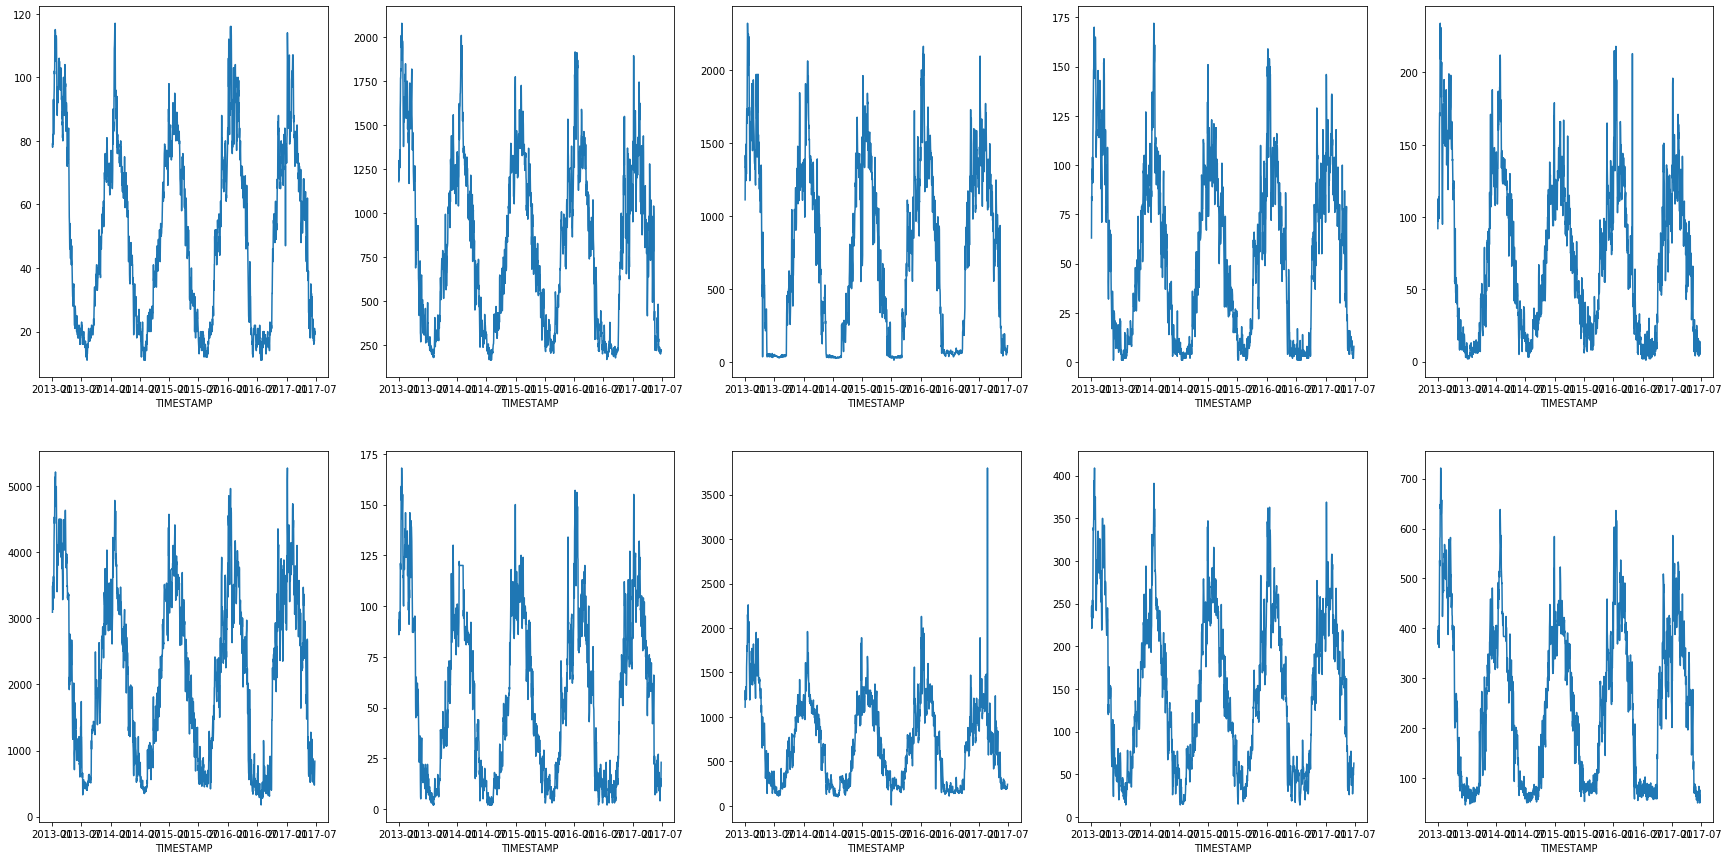

In [221]:
df_selected = df_wide.loc[:,list(y_pred==1)].iloc[:, 20:30]
plt.figure(figsize=(30,15))
for i in range(10):
    plt.subplot(2, 5, i+1)
    o=df_selected[df_selected.columns[i]]
    #o_norm = (o-o.min())/(o.max()-o.min())
    o.plot()

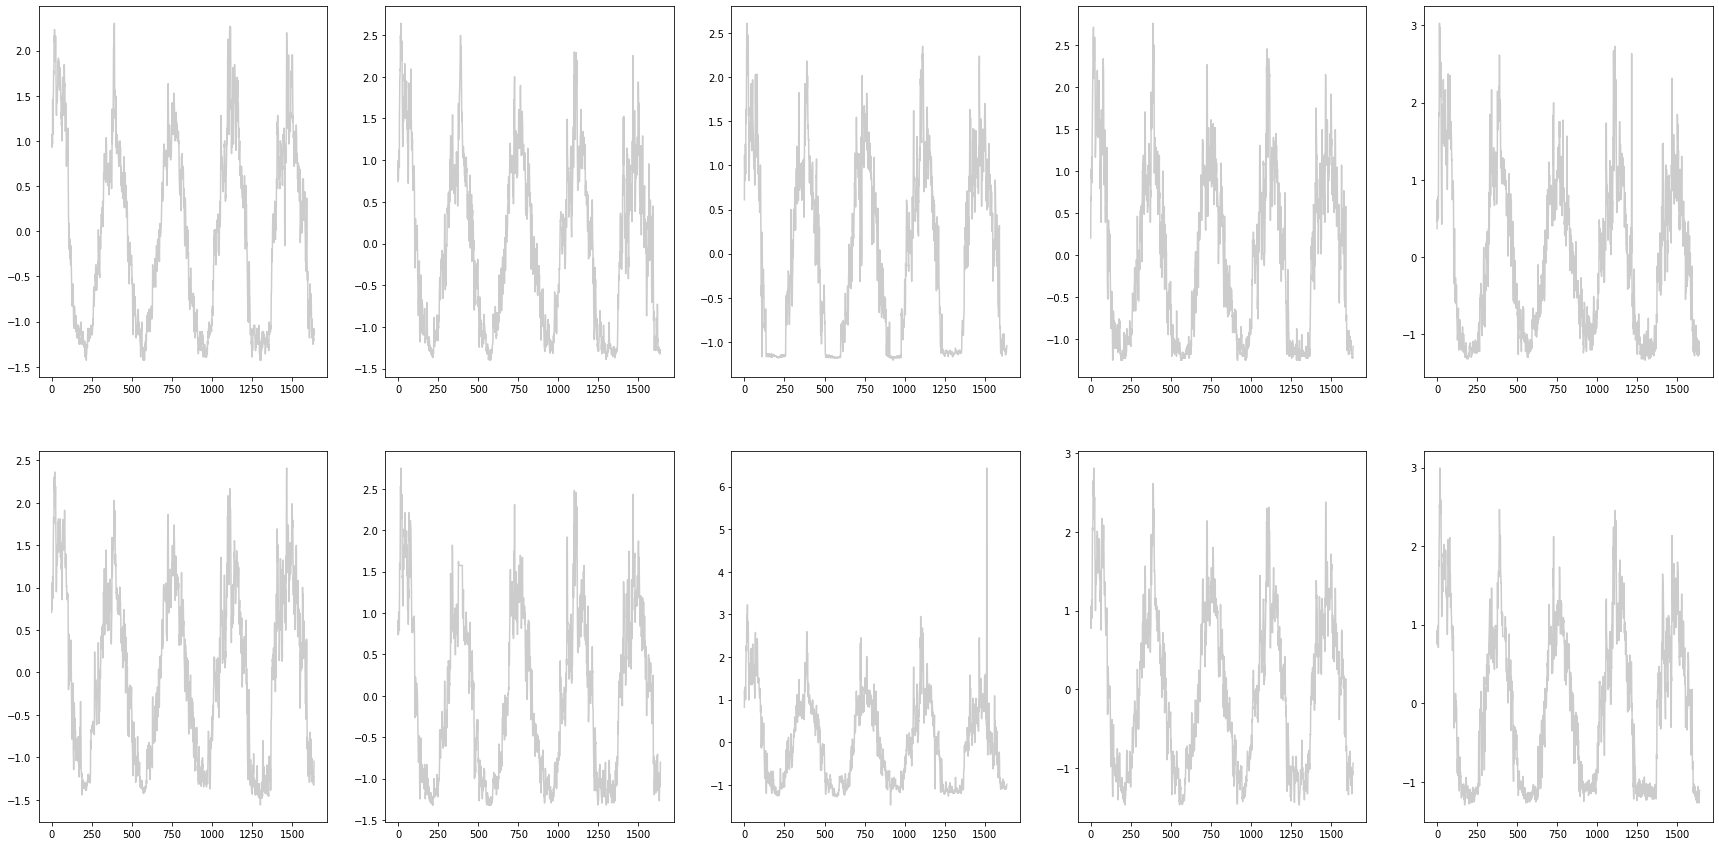

In [217]:
plt.figure(figsize=(30,15))
for i,xx in enumerate(X_train_orig[y_pred==1][20:30]):
    plt.subplot(2, 5, i+1)
    plt.plot(xx.ravel(), "k-", alpha=.2)

## Testa forecasting

In [485]:
def prepare_for_prophet(df):
    df = df.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])
    return df

#validation: 2016-06-27 tom 2017-06-26
def divide_into_train_and_test(df):
    train = df[df.ds <= '2015-06-27']
    test = df[(df.ds > '2015-06-27') & (df.ds<='2016-06-26')]
    return train, test

def mean_absolute_percentage_error(y_pred, y_true):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

from sklearn.metrics import mean_squared_error

def print_errors(y_pred, y_true):
    print('MAPE: ', round(mean_absolute_percentage_error(y_pred, y_true), 2), '\nRMSE: ', round(mean_squared_error(y_pred, y_true, squared=False), 2))

In [232]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [363]:
df = prepare_for_prophet(df_selected[df_selected.columns[0]])
train, test = divide_into_train_and_test(df)

In [276]:
m = Prophet(weekly_seasonality=False)
m.fit(train)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


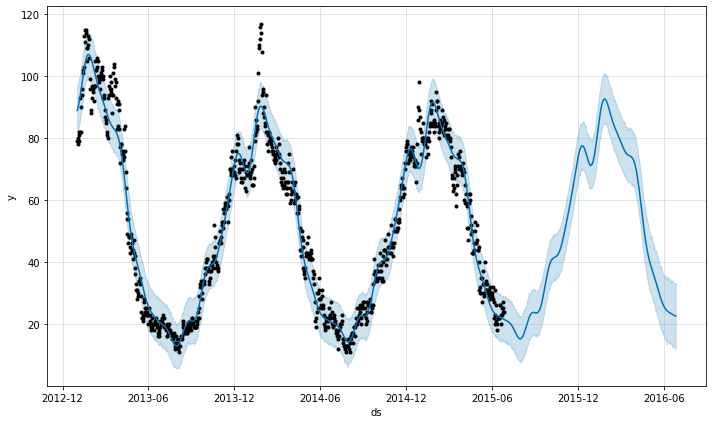

In [277]:
fig = m.plot(forecast)

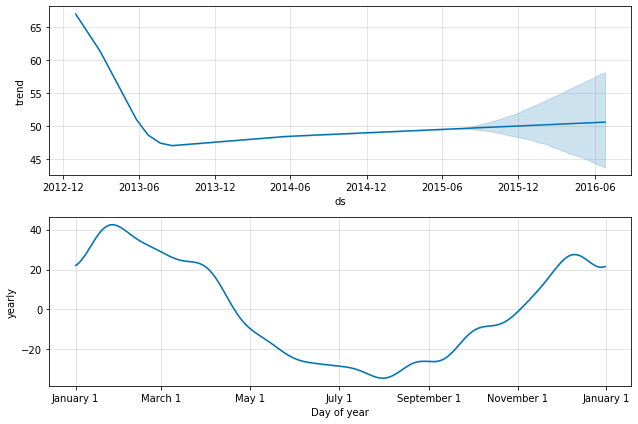

In [278]:
fig = m.plot_components(forecast)

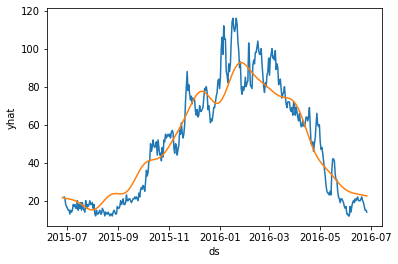

In [279]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])

In [282]:
print_errors(forecast.yhat[-365:], test.y)

MAPE:  21.33 
RMSE:  9.65


Läs in lufttemperatur för Helsingborg

In [319]:
temp = pd.read_csv('data/HelsingborgA_lufttemperatur_dygn.csv', skiprows=9, sep=';')
temp['Representativt dygn'] = pd.to_datetime(temp['Representativt dygn'])
temp.head()

Från Datum Tid (UTC) Till Datum Tid (UTC) Representativt dygn  \
0  1995-08-01 00:00:01  1995-08-02 00:00:00          1995-08-01   
1  1995-08-02 00:00:01  1995-08-03 00:00:00          1995-08-02   
2  1995-08-03 00:00:01  1995-08-04 00:00:00          1995-08-03   
3  1995-08-04 00:00:01  1995-08-05 00:00:00          1995-08-04   
4  1995-08-05 00:00:01  1995-08-06 00:00:00          1995-08-05   

   Lufttemperatur Kvalitet  Unnamed: 5  \
0            20.8        Y         NaN   
1            21.4        Y         NaN   
2            20.2        Y         NaN   
3            20.7        Y         NaN   
4            20.3        Y         NaN   

                                        Tidsutsnitt:  
0  Kvalitetskontrollerade historiska data (utom d...  
1   Tidsperiod (fr.o.m.) = 1995-08-01 00:00:00 (UTC)  
2    Tidsperiod (t.o.m.) = 2020-03-01 06:00:00 (UTC)  
3            Medelvärdet är beräknat för = 24 timmar  
4                                                NaN

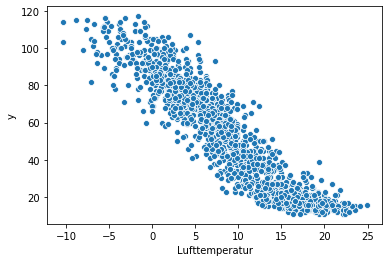

In [364]:
df_temp = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp)

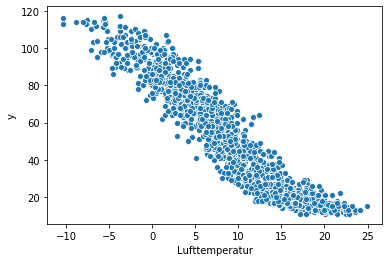

In [365]:
df['ds-1'] = df['ds'] - pd.DateOffset(days=1)
df['ds+1'] = df['ds'] + pd.DateOffset(days=1)

df_temp_minus1 = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds-1', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp_minus1)

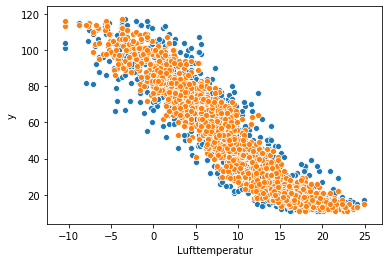

In [366]:
df_temp_plus1 = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds+1', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp_plus1)
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp_minus1)

In [323]:
print(df_temp['y'].corr(df_temp['Lufttemperatur']), df_temp_minus1['y'].corr(df_temp_minus1['Lufttemperatur']), df_temp_plus1['y'].corr(df_temp_plus1['Lufttemperatur']))

-0.9492514499284984 -0.9539156352495307 -0.9306440922249924


Att skifta energikonsumtion 1 dag framåt ger högst korrelation med lufttemperatur från Helsingborg A mätstation

## Testa Prophet med extra regressor temperatur

In [324]:
temp['Representativt dygn'] = temp['Representativt dygn'] - pd.DateOffset(days=1)
temp['Temp_K'] = temp.Lufttemperatur+273.15
temp['Temp_K_norm'] = (temp.Temp_K-temp.Temp_K)/((15+273.15)-temp.Temp_K.min()).clip(1.)

In [330]:
df_temp = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds', right_on='Representativt dygn', how='left')

train, test = divide_into_train_and_test(df_temp)

m_temp = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True,
            ).add_regressor('Lufttemperatur', prior_scale=100, mode = 'multiplicative')

m_temp.fit(train)

future_temp = m_temp.make_future_dataframe(periods=365)
future_temp['Lufttemperatur'] = df_temp['Lufttemperatur']

forecast_temp = m_temp.predict(future_temp)

print_errors(forecast_temp.yhat[-365:], test.y)

MAPE:  15.74 
RMSE:  9.06


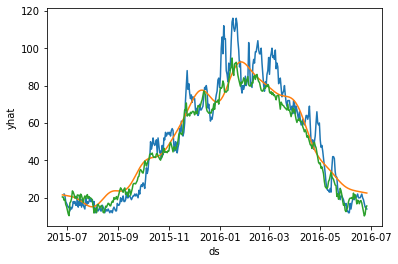

In [331]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp[forecast_temp.ds>='2015-06-26'])

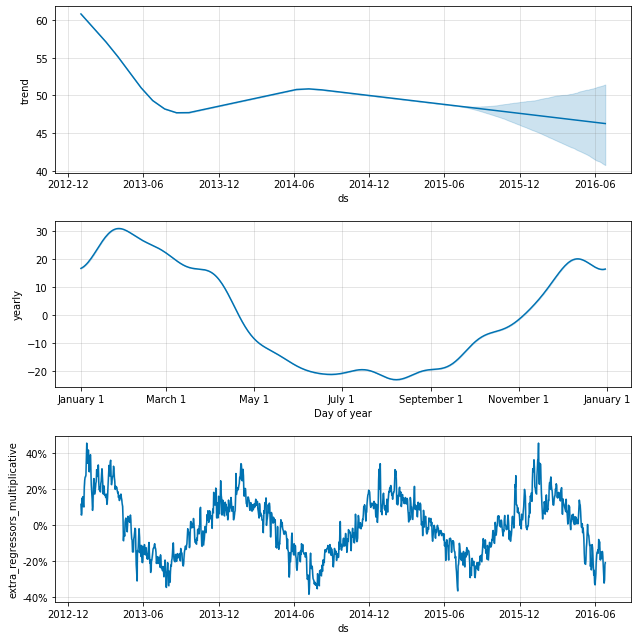

In [327]:
fig = m_temp.plot_components(forecast_temp)

Problemet med låg förklaringsgrad med hjälp av temperatur beror på hög variation per temperatur för konsumtion alt. lägre korrelation temperatur/konsumtion än för TDS9

In [333]:
df_selected

METERING_POINT_ID  05af2fa8-71c0-11ea-ae00-062fc13530dc  \
TIMESTAMP                                                 
2013-01-01                                         79.0   
2013-01-02                                         78.0   
2013-01-03                                         80.0   
2013-01-04                                         82.0   
2013-01-05                                         81.0   
...                                                 ...   
2017-06-22                                         18.0   
2017-06-23                                         17.0   
2017-06-24                                         21.0   
2017-06-25                                         19.0   
2017-06-26                                         20.0   

METERING_POINT_ID  066e8dc0-7086-11ea-ae00-062fc13530dc  \
TIMESTAMP                                                 
2013-01-01                                       1180.0   
2013-01-02                                       1300.0   
2013-01-03                                       1190.0   
2013-01-04                                       1250.0   
2013-01-05                                       1290.0   
...                                                 ...   
2017-06-22                                        201.0   
2017-06-23                                        218.0   
2017-06-24                                        214.0   
2017-06-25                                        226.0   
2017-06-26                                        223.0   

METERING_POINT_ID  06e30e72-70ac-11ea-ae00-062fc13530dc  \
TIMESTAMP                                                 
2013-01-01                                       1110.0   
2013-01-02                                       1415.0   
2013-01-03                                       1332.0   
2013-01-04                                       1336.0   
2013-01-05                                       1281.0   
...                                                 ...   
2017-06-22                                         79.0   
2017-06-23                                         62.0   
2017-06-24                                         74.0   
2017-06-25                                         93.0   
2017-06-26                                        110.0   

METERING_POINT_ID  070bfee4-7143-11ea-ae00-062fc13530dc  \
TIMESTAMP                                                 
2013-01-01                                         63.0   
2013-01-02                                         84.0   
2013-01-03                                         82.0   
2013-01-04                                         96.0   
2013-01-05                                         98.0   
...                                                 ...   
2017-06-22                                          3.0   
2017-06-23                                          2.0   
2017-06-24                                          5.0   
2017-06-25                                          6.0   
2017-06-26                                          8.0   

METERING_POINT_ID  0710e7ea-71a9-11ea-ae00-062fc13530dc  \
TIMESTAMP                                                 
2013-01-01                                         92.0   
2013-01-02                                        112.0   
2013-01-03                                         97.0   
2013-01-04                                         98.0   
2013-01-05                                        113.0   
...                                                 ...   
2017-06-22                                          6.0   
2017-06-23                                         14.0   
2017-06-24                                          5.0   
2017-06-25                                          7.0   
2017-06-26                                          9.0   

METERING_POINT_ID  076ee926-7091-11ea-ae00-062fc13530dc  \
TIMESTAMP                                                 
2013-01-01                                

In [367]:
temp['Interval'] = pd.cut(temp['Lufttemperatur'], [-100, 2, 9, 15, 100])

df_test = df.merge(temp[['Representativt dygn', 'Lufttemperatur', 'Interval']], left_on='ds', right_on='Representativt dygn', how='left')
df_test['mean_y'] = df_test.groupby('Interval')['y'].transform('mean')
df_test['res_mean'] = df_test['y'] - df_test['mean_y']
df_test.res_mean.std()

11.98140922249406

In [345]:
df_test

ds     y       ds-1       ds+1 Representativt dygn  \
0    2013-01-01  79.0 2012-12-31 2013-01-02          2013-01-01   
1    2013-01-02  78.0 2013-01-01 2013-01-03          2013-01-02   
2    2013-01-03  80.0 2013-01-02 2013-01-04          2013-01-03   
3    2013-01-04  82.0 2013-01-03 2013-01-05          2013-01-04   
4    2013-01-05  81.0 2013-01-04 2013-01-06          2013-01-05   
...         ...   ...        ...        ...                 ...   
1633 2017-06-22  18.0 2017-06-21 2017-06-23          2017-06-22   
1634 2017-06-23  17.0 2017-06-22 2017-06-24          2017-06-23   
1635 2017-06-24  21.0 2017-06-23 2017-06-25          2017-06-24   
1636 2017-06-25  19.0 2017-06-24 2017-06-26          2017-06-25   
1637 2017-06-26  20.0 2017-06-25 2017-06-27          2017-06-26   

      Lufttemperatur   Interval     mean_y   res_mean  
0                3.9     (2, 9]  67.154499  11.845501  
1                6.4     (2, 9]  67.154499  10.845501  
2                6.0     (2, 9]  67.154499  12.845501  
3                2.4     (2, 9]  67.154499  14.845501  
4                4.4     (2, 9]  67.154499  13.845501  
...              ...        ...        ...        ...  
1633            16.6  (15, 100]  18.582447  -0.582447  
1634            15.5  (15, 100]  18.582447  -1.582447  
1635            15.3  (15, 100]  18.582447   2.417553  
1636            14.4    (9, 15]  33.936430 -14.936430  
1637            14.9    (9, 15]  33.936430 -13.936430  

[1638 rows x 9 columns]

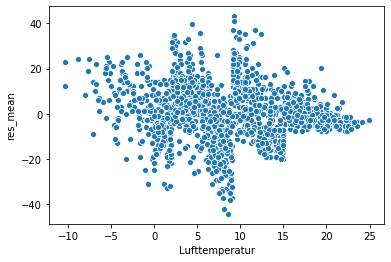

In [368]:
sns.scatterplot(x='Lufttemperatur', y='res_mean', data=df_test)

In [369]:
from backend.Matrix import Matrix
from backend.Group import Group
from backend.Point import Point
#from standard_deviation import StandardDeviation #Kopierad från källkoden, går ej att importera

#temperaturintervall, hårdkodat i _default_controller.py
BREAKPOINTS = [-5, 2, 9, 15, 20]

def fill_points_with_data(df):
    points = []
    for index, row in df.iterrows():
        point = Point()
        point.temp = float(row['Lufttemperatur'])
        try:
            point.reading = row['y'] 
            point.timestamp = row['ds']
            point.consumption_timestamp = row['ds']
            point.breakpoints = BREAKPOINTS
        except:
            None
        points.append(point)
    return points

points_energy = fill_points_with_data(df_test)

g_energy = Group()
g_energy.set_breakpoints(BREAKPOINTS)
g_energy.set_points(points_energy)

koff = g_energy.calcKoff()
g_energy.updatePointRegression(koff)

df_test['Regression'] = [point.regression for point in g_energy.points]
df_test['res_reg'] = df_test['y'] - df_test['Regression'] 


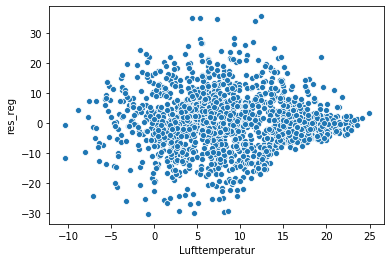

In [370]:


sns.scatterplot(x='Lufttemperatur', y='res_reg', data=df_test)

In [371]:
df_test.res_reg.std()

9.371673886332426

In [381]:
stds = []
df_group2 = df_wide.loc[:,list(y_pred==1)]

for i in range(df_group2.shape[1]):
    if i%100==0:
        print(i)
    df_temp = prepare_for_prophet(df_group2[df_group2.columns[i]])
    df_test_temp = df_temp.merge(temp[['Representativt dygn', 'Lufttemperatur', 'Interval']], left_on='ds', right_on='Representativt dygn', how='left')
    points_energy = fill_points_with_data(df_test_temp)

    g_energy = Group()
    g_energy.set_breakpoints(BREAKPOINTS)
    g_energy.set_points(points_energy)
    
    koff = g_energy.calcKoff()
    g_energy.updatePointRegression(koff)
    
    df_test_temp['Regression'] = [point.regression for point in g_energy.points]
    df_test_temp['res_reg'] = df_test_temp['y'] - df_test_temp['Regression'] 
    stds.append(df_test_temp['res_reg'].std())

0
100
200
300
400
500
600
700
800


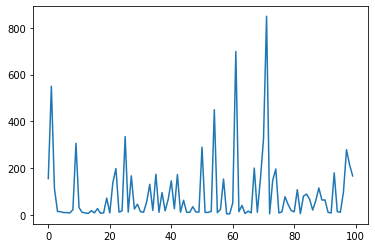

In [361]:
plt.plot(np.linspace(0,99,100), stds)

In [395]:
lowest_std = np.argsort(stds)
lowest_std[:10]

array([171, 523,  59, 446,  58,  72, 622, 699, 831, 260], dtype=int64)

In [383]:
stds[171]

4.7645370120842205

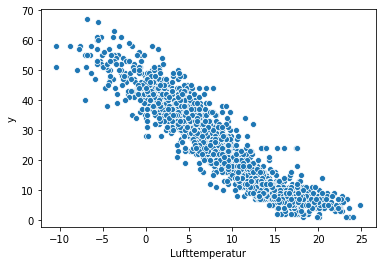

In [384]:
df_temp = prepare_for_prophet(df_group2[df_group2.columns[171]])
df_test_temp = df_temp.merge(temp[['Representativt dygn', 'Lufttemperatur', 'Interval']], left_on='ds', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_test_temp)

Även anläggningen med lägst standardavvikelse har en ful temperaturkurva :(

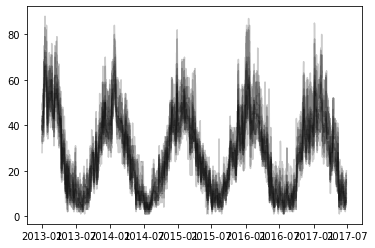

In [444]:
df_selected2 = df_group2.iloc[:, lowest_std[:20]]
for i in range(10):
    xx = df_selected2[df_selected2.columns[i]]
    plt.plot(xx, "k-", alpha=.2)

Skapa lista med dataframes

In [455]:
dfs = [df_selected2[df_selected2.columns[i]] for i in range(20)]
dfs[0]

TIMESTAMP
2013-01-01    33.0
2013-01-02    36.0
2013-01-03    35.0
2013-01-04    33.0
2013-01-05    35.0
              ... 
2017-06-22     9.0
2017-06-23     6.0
2017-06-24     7.0
2017-06-25    12.0
2017-06-26     8.0
Name: 3057cf7a-7289-11ea-ae02-062fc13530dc, Length: 1638, dtype: float64

In [456]:
len(dfs)

20

Förbered för prophet och lägg till lufttemperatur till varje df

In [457]:
dfs = [prepare_for_prophet(df) for df in dfs]
dfs = [df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds', right_on='Representativt dygn', how='left') for df in dfs]
dfs[0]

ds     y Representativt dygn  Lufttemperatur
0    2013-01-01  33.0          2013-01-01             3.9
1    2013-01-02  36.0          2013-01-02             6.4
2    2013-01-03  35.0          2013-01-03             6.0
3    2013-01-04  33.0          2013-01-04             2.4
4    2013-01-05  35.0          2013-01-05             4.4
...         ...   ...                 ...             ...
1633 2017-06-22   9.0          2017-06-22            16.6
1634 2017-06-23   6.0          2017-06-23            15.5
1635 2017-06-24   7.0          2017-06-24            15.3
1636 2017-06-25  12.0          2017-06-25            14.4
1637 2017-06-26   8.0          2017-06-26            14.9

[1638 rows x 4 columns]

In [458]:
len(dfs)

20

In [513]:
def train_prophet(df, regressor_list = None, periods=365):
    if periods == 365:
        train, test = divide_into_train_and_test(df)
    else:
        train, test = divide_into_train_and_test_halfyear(df)

    m = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True)
    
    if regressor_list:
        for r in regressor_list:
            m.add_regressor(r, prior_scale=100, mode = 'multiplicative')
    
    m.fit(train)
    future= m.make_future_dataframe(periods=periods)
    
    if regressor_list:
        for r in regressor_list:
            future[r] = df[r]
    
    forecast = m.predict(future)    
    return forecast, future, m

def train_K2(df, d_min, d_max, output_name = 'K2_regression'):
    points_energy_ref = fill_points_with_data(df[(df.ds >= d_min) & (df.ds <= d_max)])
    points_energy = fill_points_with_data(df)

    g_energy_ref = Group()
    g_energy_ref.set_breakpoints(BREAKPOINTS)
    g_energy_ref.set_points(points_energy_ref)
    
    g_energy = Group()
    g_energy.set_breakpoints(BREAKPOINTS)
    g_energy.set_points(points_energy)
    
    koff = g_energy_ref.calcKoff()
    g_energy.updatePointRegression(koff)
    
    df[output_name] = [point.regression for point in g_energy.points]
    return df

In [514]:
dfs = [train_K2(df, d_min ='2014-01-01', d_max = '2014-12-31', output_name = 'K2_regression_2014') for df in dfs]
dfs[0]

ds     y Representativt dygn  Lufttemperatur  \
0    2013-01-01  33.0          2013-01-01             3.9   
1    2013-01-02  36.0          2013-01-02             6.4   
2    2013-01-03  35.0          2013-01-03             6.0   
3    2013-01-04  33.0          2013-01-04             2.4   
4    2013-01-05  35.0          2013-01-05             4.4   
...         ...   ...                 ...             ...   
1633 2017-06-22   9.0          2017-06-22            16.6   
1634 2017-06-23   6.0          2017-06-23            15.5   
1635 2017-06-24   7.0          2017-06-24            15.3   
1636 2017-06-25  12.0          2017-06-25            14.4   
1637 2017-06-26   8.0          2017-06-26            14.9   

      Prophet_temperature_regression_halvår  K2_Regression  \
0                                 37.484313      36.408046   
1                                 34.860587      30.102653   
2                                 35.636951      31.111516   
3                                 40.163895      40.191282   
4                                 38.188844      35.146968   
...                                     ...            ...   
1633                                    NaN       7.691367   
1634                                    NaN       8.198482   
1635                                    NaN       8.290685   
1636                                    NaN       9.940594   
1637                                    NaN       8.680923   

      Prophet_regression_halvår  Prophet_regression  \
0                     42.344212           40.477010   
1                     42.950431           40.815199   
2                     43.589154           41.228481   
3                     44.253026           41.712468   
4                     44.934286           42.261472   
...                         ...                 ...   
1633                        NaN                 NaN   
1634                        NaN                 NaN   
1635                        NaN                 NaN   
1636                        NaN                 NaN   
1637                        NaN                 NaN   

      Prophet_temperature_regression  K2_regression_2014  
0                          36.884590           37.360006  
1                          34.272229           29.955188  
2                          34.931652           31.139958  
3                          39.198726           41.802896  
4                          37.268811           35.879042  
...                              ...                 ...  
1633                             NaN            7.386327  
1634                             NaN            7.965771  
1635                             NaN            8.071124  
1636                             NaN            9.631657  
1637                             NaN            8.462905  

[1638 rows x 10 columns]

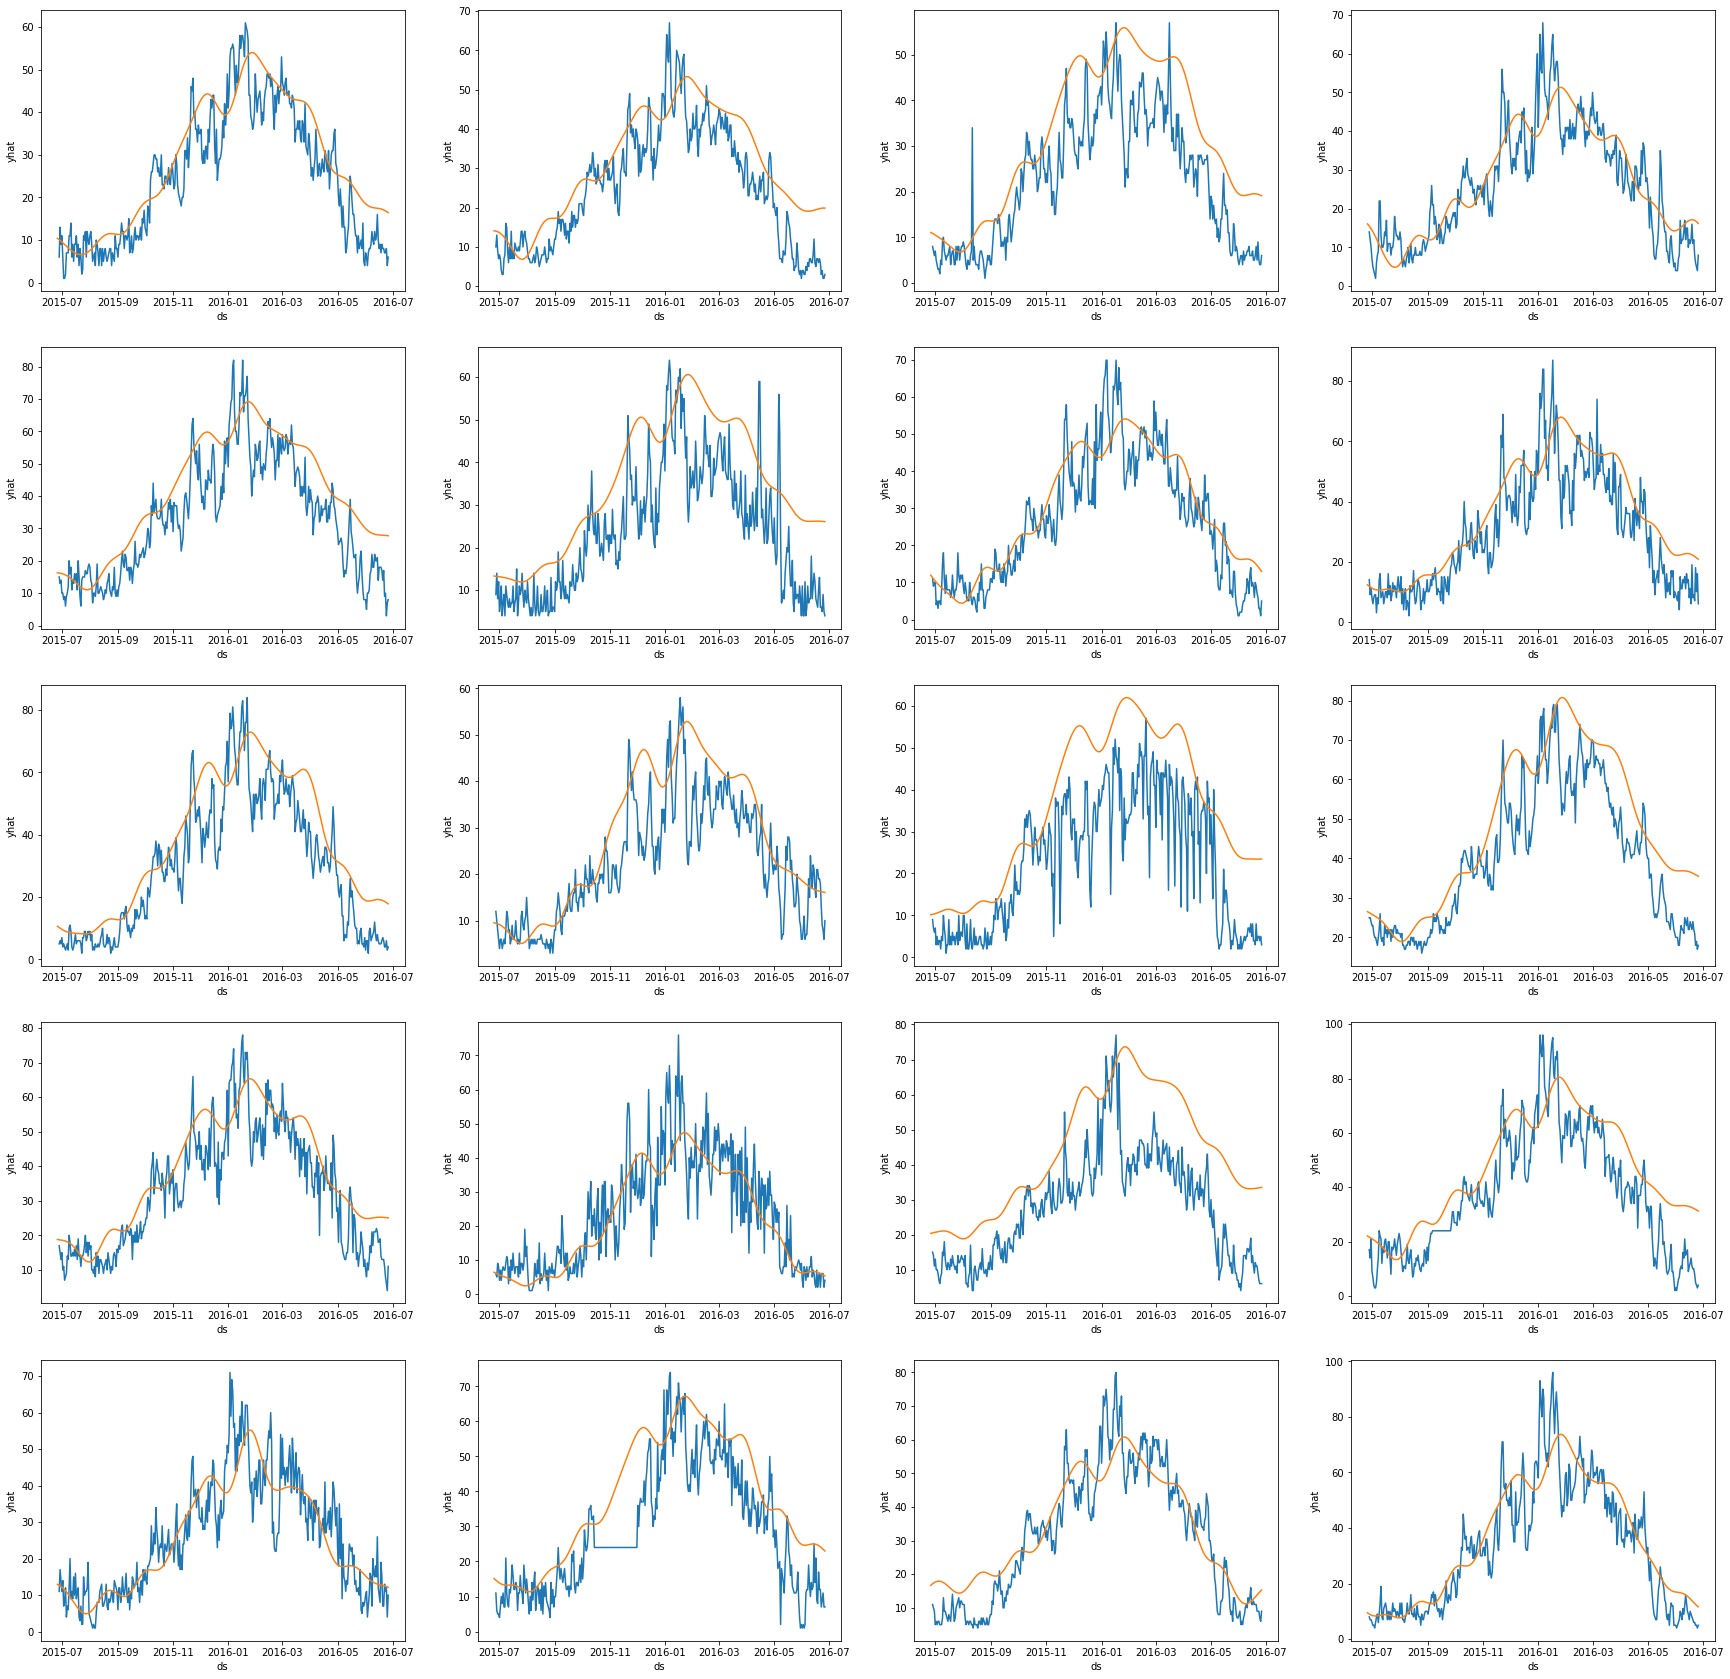

In [487]:
results = pd.DataFrame()

rmsd = []
plt.figure(figsize=(30,30))
for i, df in enumerate(dfs):
    forecast, future, m = train_prophet(df)
    test = divide_into_train_and_test(df)[1]
    df['Prophet_regression'] = forecast.yhat
    rmsd.append(round(mean_squared_error(forecast.yhat[-365:], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(5,4,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=test)
    sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])
    
results['rmsd'] = rmsd


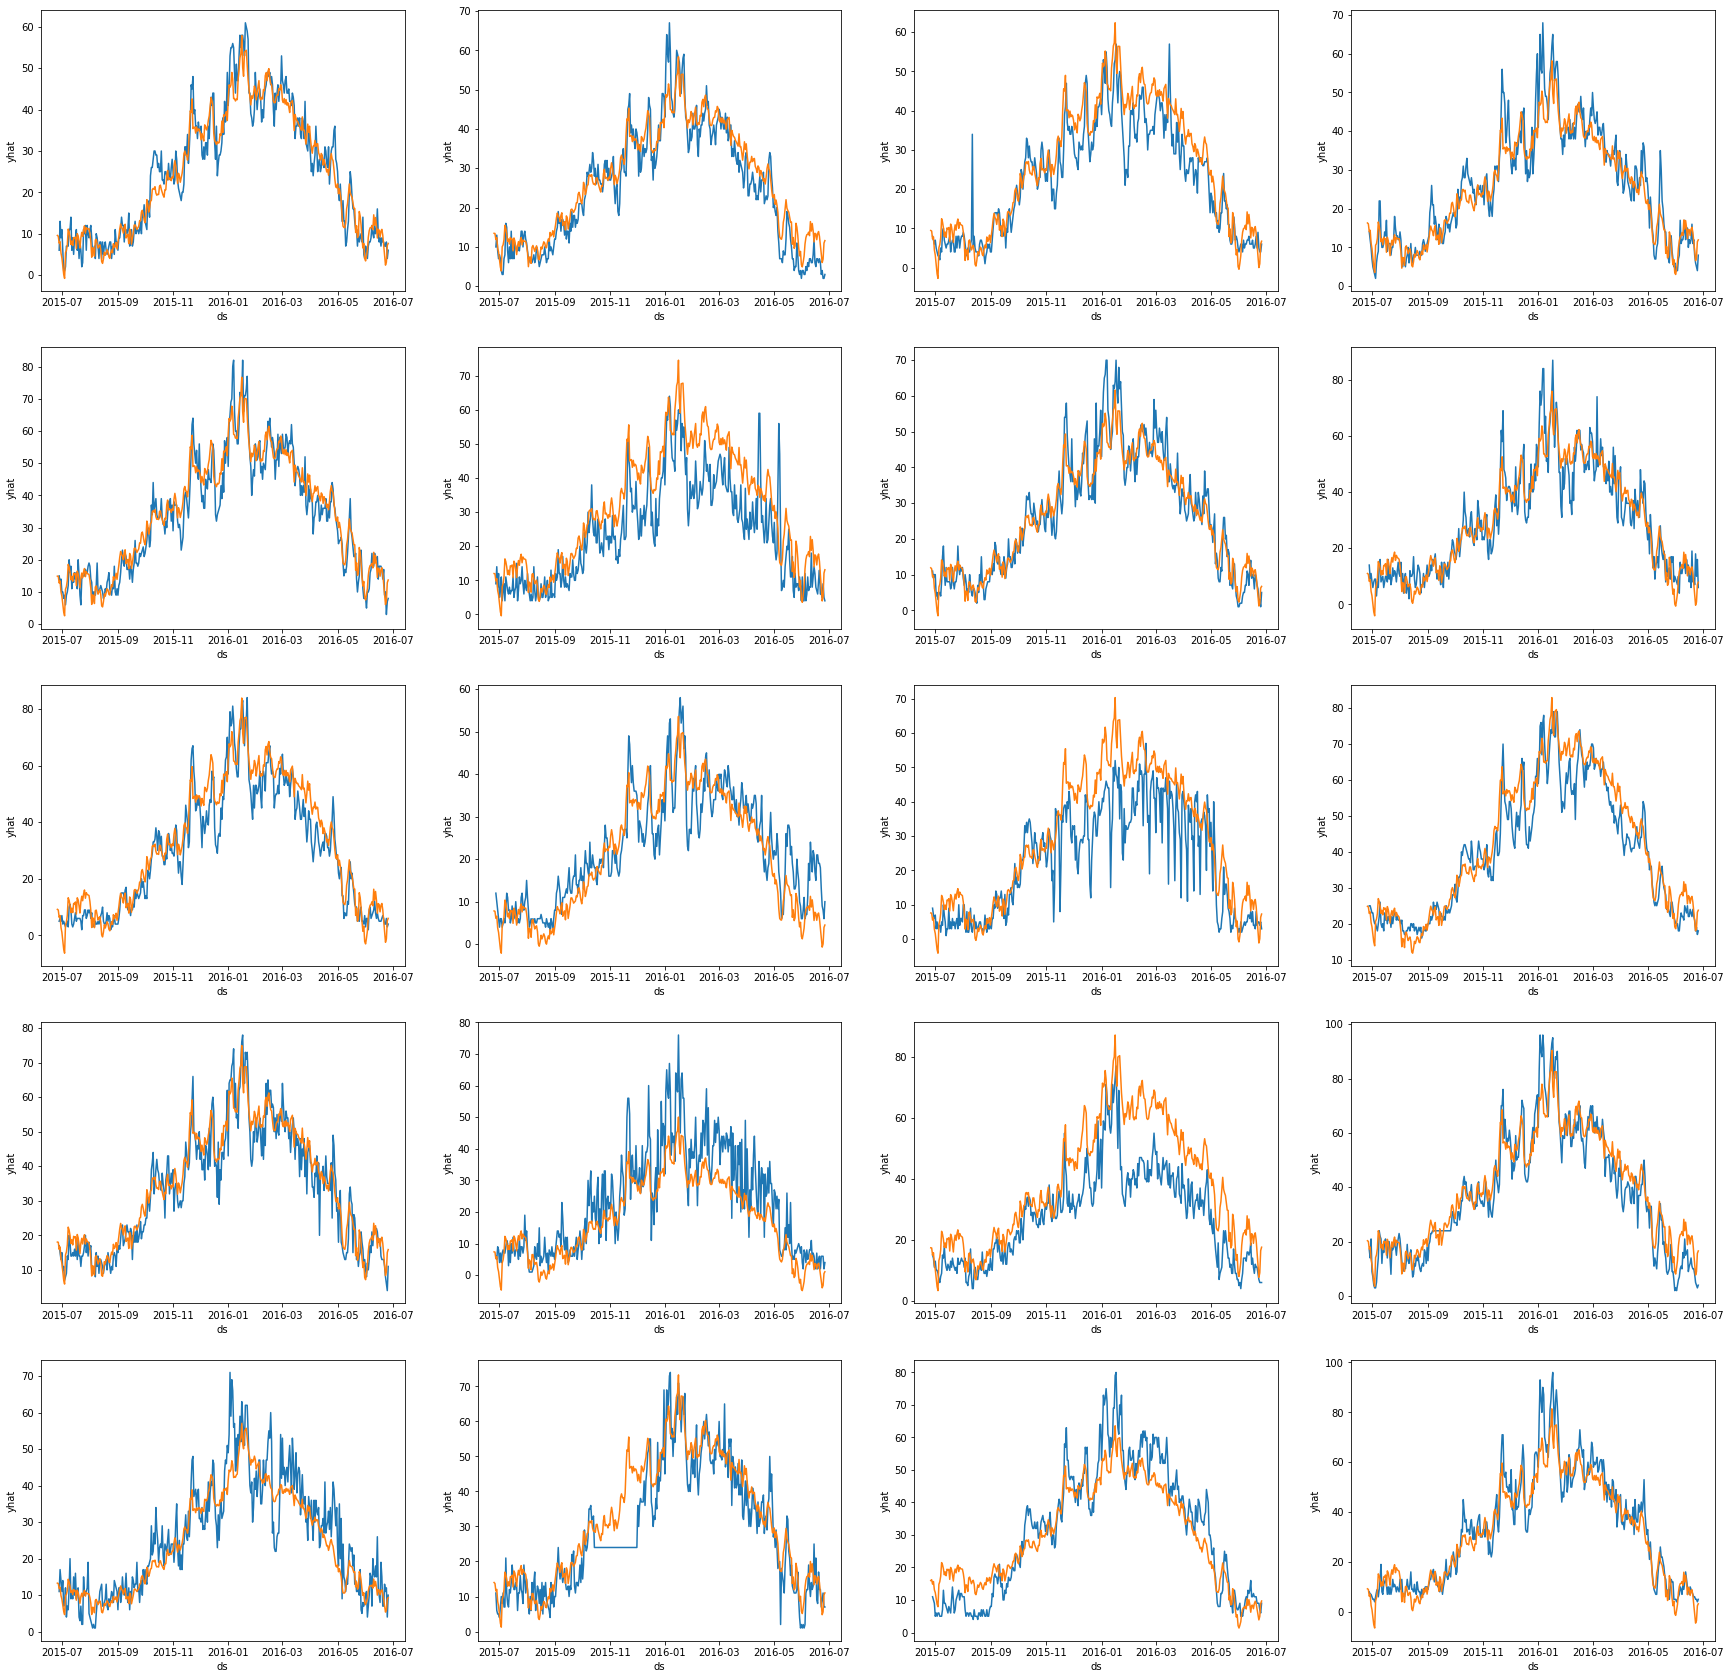

In [488]:
rmsd = []

plt.figure(figsize=(30,30))
for i, df in enumerate(dfs):
    forecast, future, m = train_prophet(df, regressor_list=['Lufttemperatur'])
    test = divide_into_train_and_test(df)[1]
    df['Prophet_temperature_regression'] = forecast.yhat
    rmsd.append(round(mean_squared_error(forecast.yhat[-365:], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(5,4,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=test)
    sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])
    
results['rmsd_temp'] = rmsd

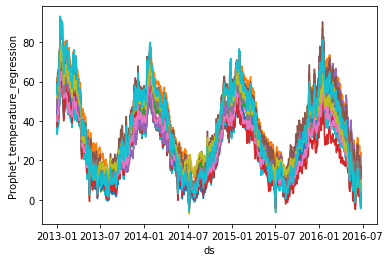

In [490]:
#plt.figure(figsize=(30,30))
for i, df in enumerate(dfs):
    #plt.subplot(5,4,i+1)
    #sns.lineplot(x = 'ds', y = 'y', data=df)
    sns.lineplot(x = 'ds', y = 'Prophet_temperature_regression', data=df)

In [515]:
rmsd = []
for df in dfs:
    df_test = df[(df.ds > '2015-06-27') & (df.ds<='2016-06-26')]
    rmsd.append(round(mean_squared_error(df_test.K2_regression_2014, df_test.y, squared=False), 2))
results['rmsd_K2_2014'] = rmsd

In [516]:
results

rmsd  rmsd_temp  rmsd_K2  rmsd_temp_halvår  rmsd_K2_halvår  rmsd_K2_2014
0    7.43       4.14     4.72              4.46            4.75          4.76
1    9.22       4.78     4.80              5.04            5.40          5.17
2   11.96       6.26     5.10              4.74            5.28          5.61
3    7.39       4.94     4.95              5.16            5.01          5.39
4   11.37       5.10     5.40              5.26            5.31          5.54
5   14.10      10.51     6.43              4.64            4.58          6.57
6    8.35       5.24     5.55              4.62            5.53          6.07
7   11.23       6.83     6.30              6.22            6.34          6.43
8   12.12       6.93     5.83              6.57            6.40          6.06
9    9.08       6.25     5.84              8.56            7.60          7.51
10  16.20      10.52     6.94              4.95            4.82          6.99
11  11.23       5.94     5.78              7.52            7.18          5.85
12   9.31       5.32     5.74              7.30            6.48          5.86
13   8.82       9.38     6.26              7.17            6.95          6.61
14  18.77      13.39     5.33              5.80            6.06          5.80
15  14.17       6.77     7.12              9.78            9.00          7.49
16   7.86       6.62     6.12              5.42            6.75          6.93
17  13.09       7.65     7.60              7.10            6.84          8.18
18   8.67       7.59     6.11              6.76            6.69          9.27
19  10.09       6.76     6.21              6.19            6.90          6.71

In [494]:
results[results.rmsd_temp < results.rmsd_K2]

rmsd  rmsd_temp  rmsd_K2
0    7.43       4.14     4.72
1    9.22       4.78     4.80
3    7.39       4.94     4.95
4   11.37       5.10     5.40
6    8.35       5.24     5.55
12   9.31       5.32     5.74
15  14.17       6.77     7.12

Prophet med utomhustemperatur presterar sämre än K2, kan jag testa med halvårs test period istället?

In [499]:
def divide_into_train_and_test_halfyear(df):
    train = df[df.ds <= '2016-07-01']
    test = df[(df.ds > '2016-07-01') & (df.ds<='2016-12-31')]
    return train, test

In [431]:
from datetime import date
d0 = date(2016, 7, 1)
d1 = date(2016, 12, 31)
delta = d1 - d0
print(delta.days)

183


In [504]:
test = divide_into_train_and_test_halfyear(dfs[0])[1]
test

ds     y Representativt dygn  Lufttemperatur  \
1278 2016-07-02   7.0          2016-07-02            14.4   
1279 2016-07-03  10.0          2016-07-03            15.6   
1280 2016-07-04  15.0          2016-07-04            15.1   
1281 2016-07-05   5.0          2016-07-05            14.8   
1282 2016-07-06   6.0          2016-07-06            15.2   
...         ...   ...                 ...             ...   
1456 2016-12-27  33.0          2016-12-27             1.8   
1457 2016-12-28  33.0          2016-12-28             4.3   
1458 2016-12-29  35.0          2016-12-29             3.4   
1459 2016-12-30  33.0          2016-12-30             7.3   
1460 2016-12-31  32.0          2016-12-31             5.7   

      Prophet_temperature_regression_halvår  K2_Regression  \
1278                                    NaN       9.940594   
1279                                    NaN       8.152380   
1280                                    NaN       8.382887   
1281                                    NaN       8.932857   
1282                                    NaN       8.336786   
...                                     ...            ...   
1456                                    NaN      41.511751   
1457                                    NaN      35.399183   
1458                                    NaN      37.669125   
1459                                    NaN      27.832711   
1460                                    NaN      31.868163   

      Prophet_regression_halvår  Prophet_regression  \
1278                   7.538052                 NaN   
1279                   7.340599                 NaN   
1280                   7.151126                 NaN   
1281                   6.971420                 NaN   
1282                   6.803066                 NaN   
...                         ...                 ...   
1456                  35.674369                 NaN   
1457                  36.041749                 NaN   
1458                  36.468090                 NaN   
1459                  36.949818                 NaN   
1460                  37.482414                 NaN   

      Prophet_temperature_regression  
1278                             NaN  
1279                             NaN  
1280                             NaN  
1281                             NaN  
1282                             NaN  
...                              ...  
1456                             NaN  
1457                             NaN  
1458                             NaN  
1459                             NaN  
1460                             NaN  

[183 rows x 9 columns]

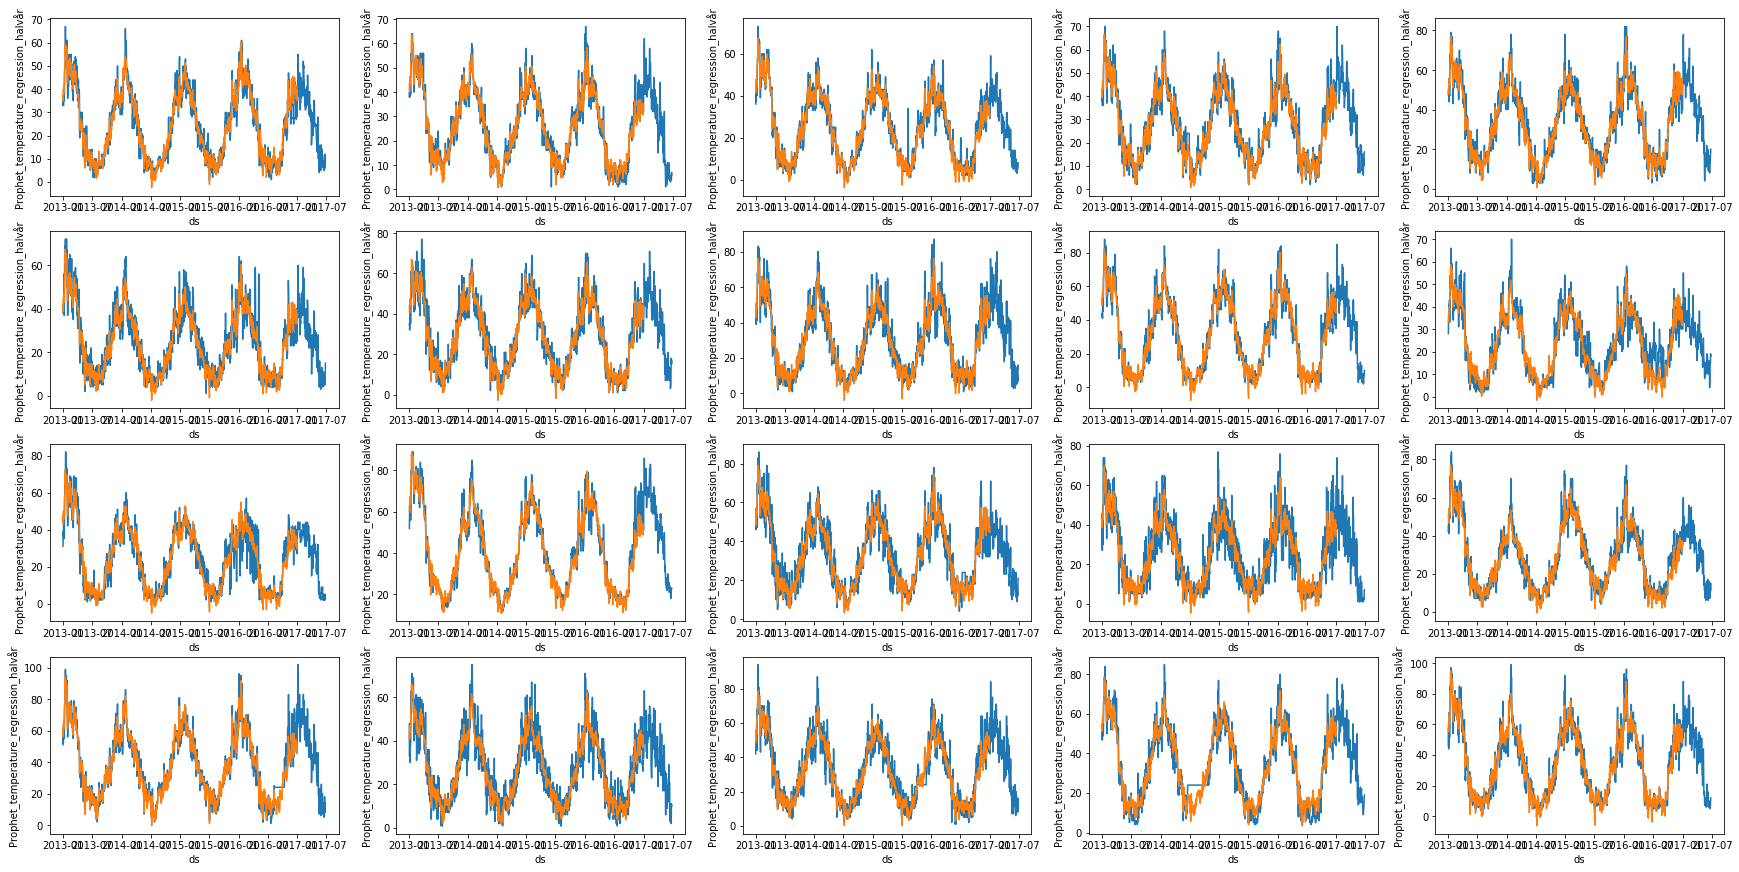

In [508]:
#results = pd.DataFrame()
rmsd = []

plt.figure(figsize=(30,15))
for i, df in enumerate(dfs):
    forecast, future, m = train_prophet(df, regressor_list=['Lufttemperatur'], periods=183)
    test = divide_into_train_and_test_halfyear(df)[1]
    df['Prophet_temperature_regression_halvår'] = forecast.yhat
    rmsd.append(round(mean_squared_error(forecast.yhat[-183:], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(4,5,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=df)
    sns.lineplot(x = 'ds', y = 'Prophet_temperature_regression_halvår', data=df)
    
results['rmsd_temp_halvår'] = rmsd

In [509]:
results

rmsd  rmsd_temp  rmsd_K2  rmsd_temp_halvår
0    7.43       4.14     4.72              4.46
1    9.22       4.78     4.80              5.04
2   11.96       6.26     5.10              4.74
3    7.39       4.94     4.95              5.16
4   11.37       5.10     5.40              5.26
5   14.10      10.51     6.43              4.64
6    8.35       5.24     5.55              4.62
7   11.23       6.83     6.30              6.22
8   12.12       6.93     5.83              6.57
9    9.08       6.25     5.84              8.56
10  16.20      10.52     6.94              4.95
11  11.23       5.94     5.78              7.52
12   9.31       5.32     5.74              7.30
13   8.82       9.38     6.26              7.17
14  18.77      13.39     5.33              5.80
15  14.17       6.77     7.12              9.78
16   7.86       6.62     6.12              5.42
17  13.09       7.65     7.60              7.10
18   8.67       7.59     6.11              6.76
19  10.09       6.76     6.21              6.19

In [517]:
rmsd = []
for df in dfs:
    df_test = df[(df.ds > '2016-07-01') & (df.ds<='2016-12-31')]
    rmsd.append(round(mean_squared_error(df_test.K2_regression_2014, df_test.y, squared=False), 2))
results['rmsd_K2_halvår'] = rmsd

In [518]:
results[results.rmsd_temp_halvår < results.rmsd_K2_halvår]

rmsd  rmsd_temp  rmsd_K2  rmsd_temp_halvår  rmsd_K2_halvår  rmsd_K2_2014
0    7.43       4.14     4.72              4.46            5.06          4.76
1    9.22       4.78     4.80              5.04            6.40          5.17
2   11.96       6.26     5.10              4.74            6.00          5.61
3    7.39       4.94     4.95              5.16            5.48          5.39
4   11.37       5.10     5.40              5.26            5.38          5.54
5   14.10      10.51     6.43              4.64            4.74          6.57
6    8.35       5.24     5.55              4.62            6.31          6.07
7   11.23       6.83     6.30              6.22            6.58          6.43
8   12.12       6.93     5.83              6.57            6.94          6.06
9    9.08       6.25     5.84              8.56            9.91          7.51
10  16.20      10.52     6.94              4.95            5.32          6.99
13   8.82       9.38     6.26              7.17            7.35          6.61
14  18.77      13.39     5.33              5.80            5.82          5.80
16   7.86       6.62     6.12              5.42            7.96          6.93
18   8.67       7.59     6.11              6.76           10.50          9.27
19  10.09       6.76     6.21              6.19            7.88          6.71

In [467]:
dfs[0]

ds     y Representativt dygn  Lufttemperatur  \
0    2013-01-01  33.0          2013-01-01             3.9   
1    2013-01-02  36.0          2013-01-02             6.4   
2    2013-01-03  35.0          2013-01-03             6.0   
3    2013-01-04  33.0          2013-01-04             2.4   
4    2013-01-05  35.0          2013-01-05             4.4   
...         ...   ...                 ...             ...   
1633 2017-06-22   9.0          2017-06-22            16.6   
1634 2017-06-23   6.0          2017-06-23            15.5   
1635 2017-06-24   7.0          2017-06-24            15.3   
1636 2017-06-25  12.0          2017-06-25            14.4   
1637 2017-06-26   8.0          2017-06-26            14.9   

      Prophet_temperature_regression_halvår  K2_Regression  
0                                 35.761002      36.408046  
1                                 33.019914      30.102653  
2                                 33.828901      31.111516  
3                                 38.543039      40.191282  
4                                 36.525696      35.146968  
...                                     ...            ...  
1633                                    NaN       7.691367  
1634                                    NaN       8.198482  
1635                                    NaN       8.290685  
1636                                    NaN       9.940594  
1637                                    NaN       8.680923  

[1638 rows x 6 columns]

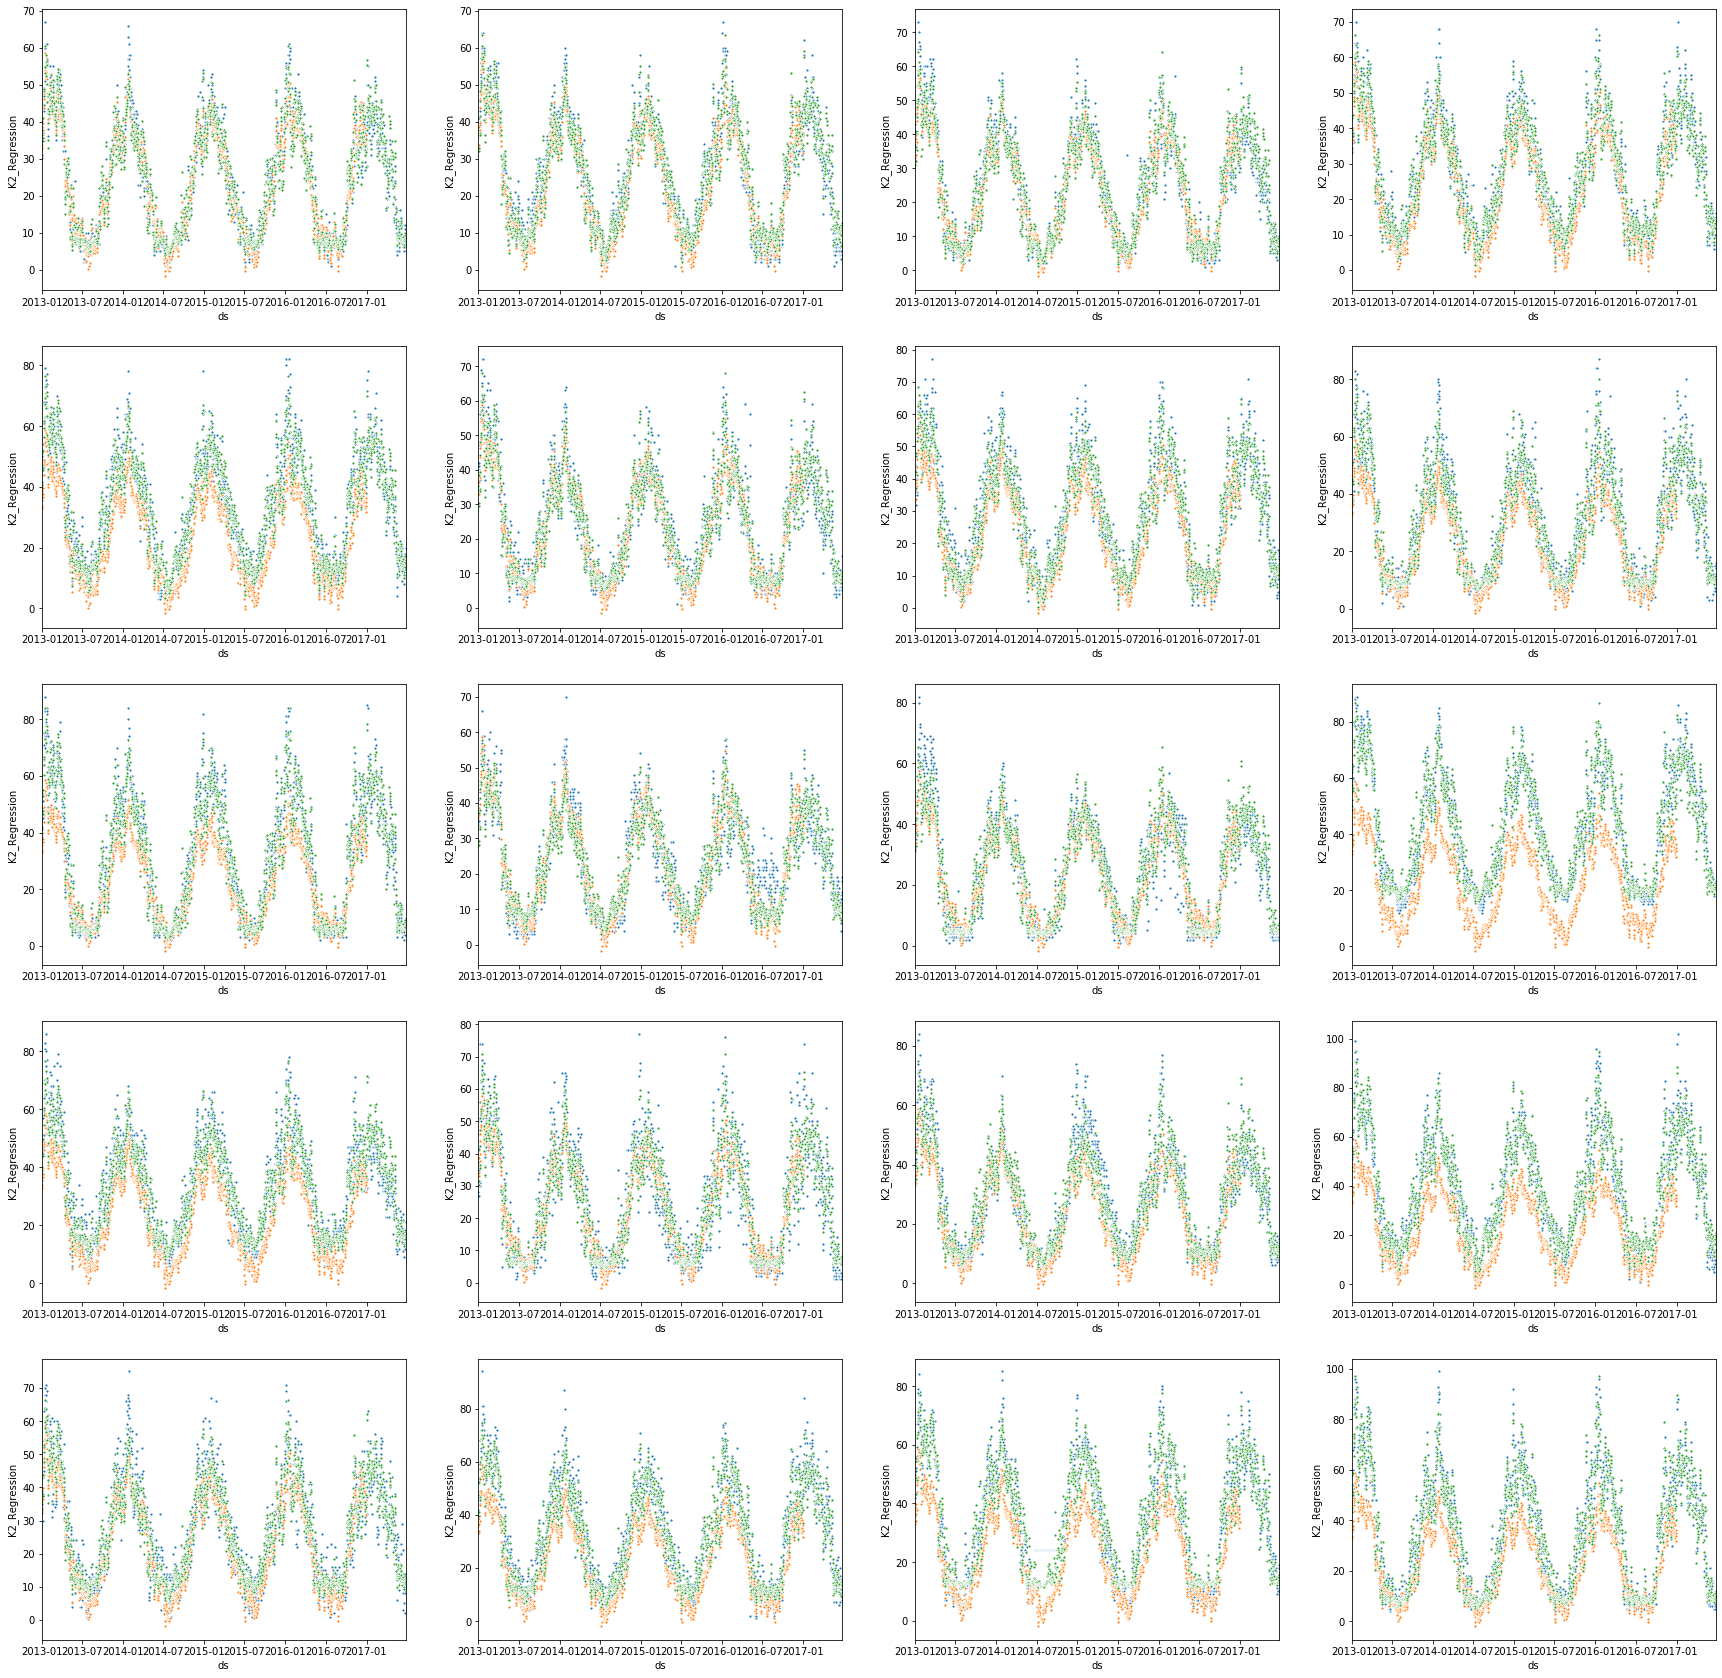

In [472]:
plt.figure(figsize=(30,30))
for i, df in enumerate(dfs):
    plt.subplot(5,4,i+1)
    sns.scatterplot(x = 'ds', y = 'y', data=df, marker = '.')
    sns.scatterplot(x = 'ds', y = 'Prophet_temperature_regression_halvår', data=df, marker = '.')
    ax = sns.scatterplot(x = 'ds', y = 'K2_Regression', data=df, marker = '.')
    ax.set_xlim(df.ds.min(), df.ds.max())
    

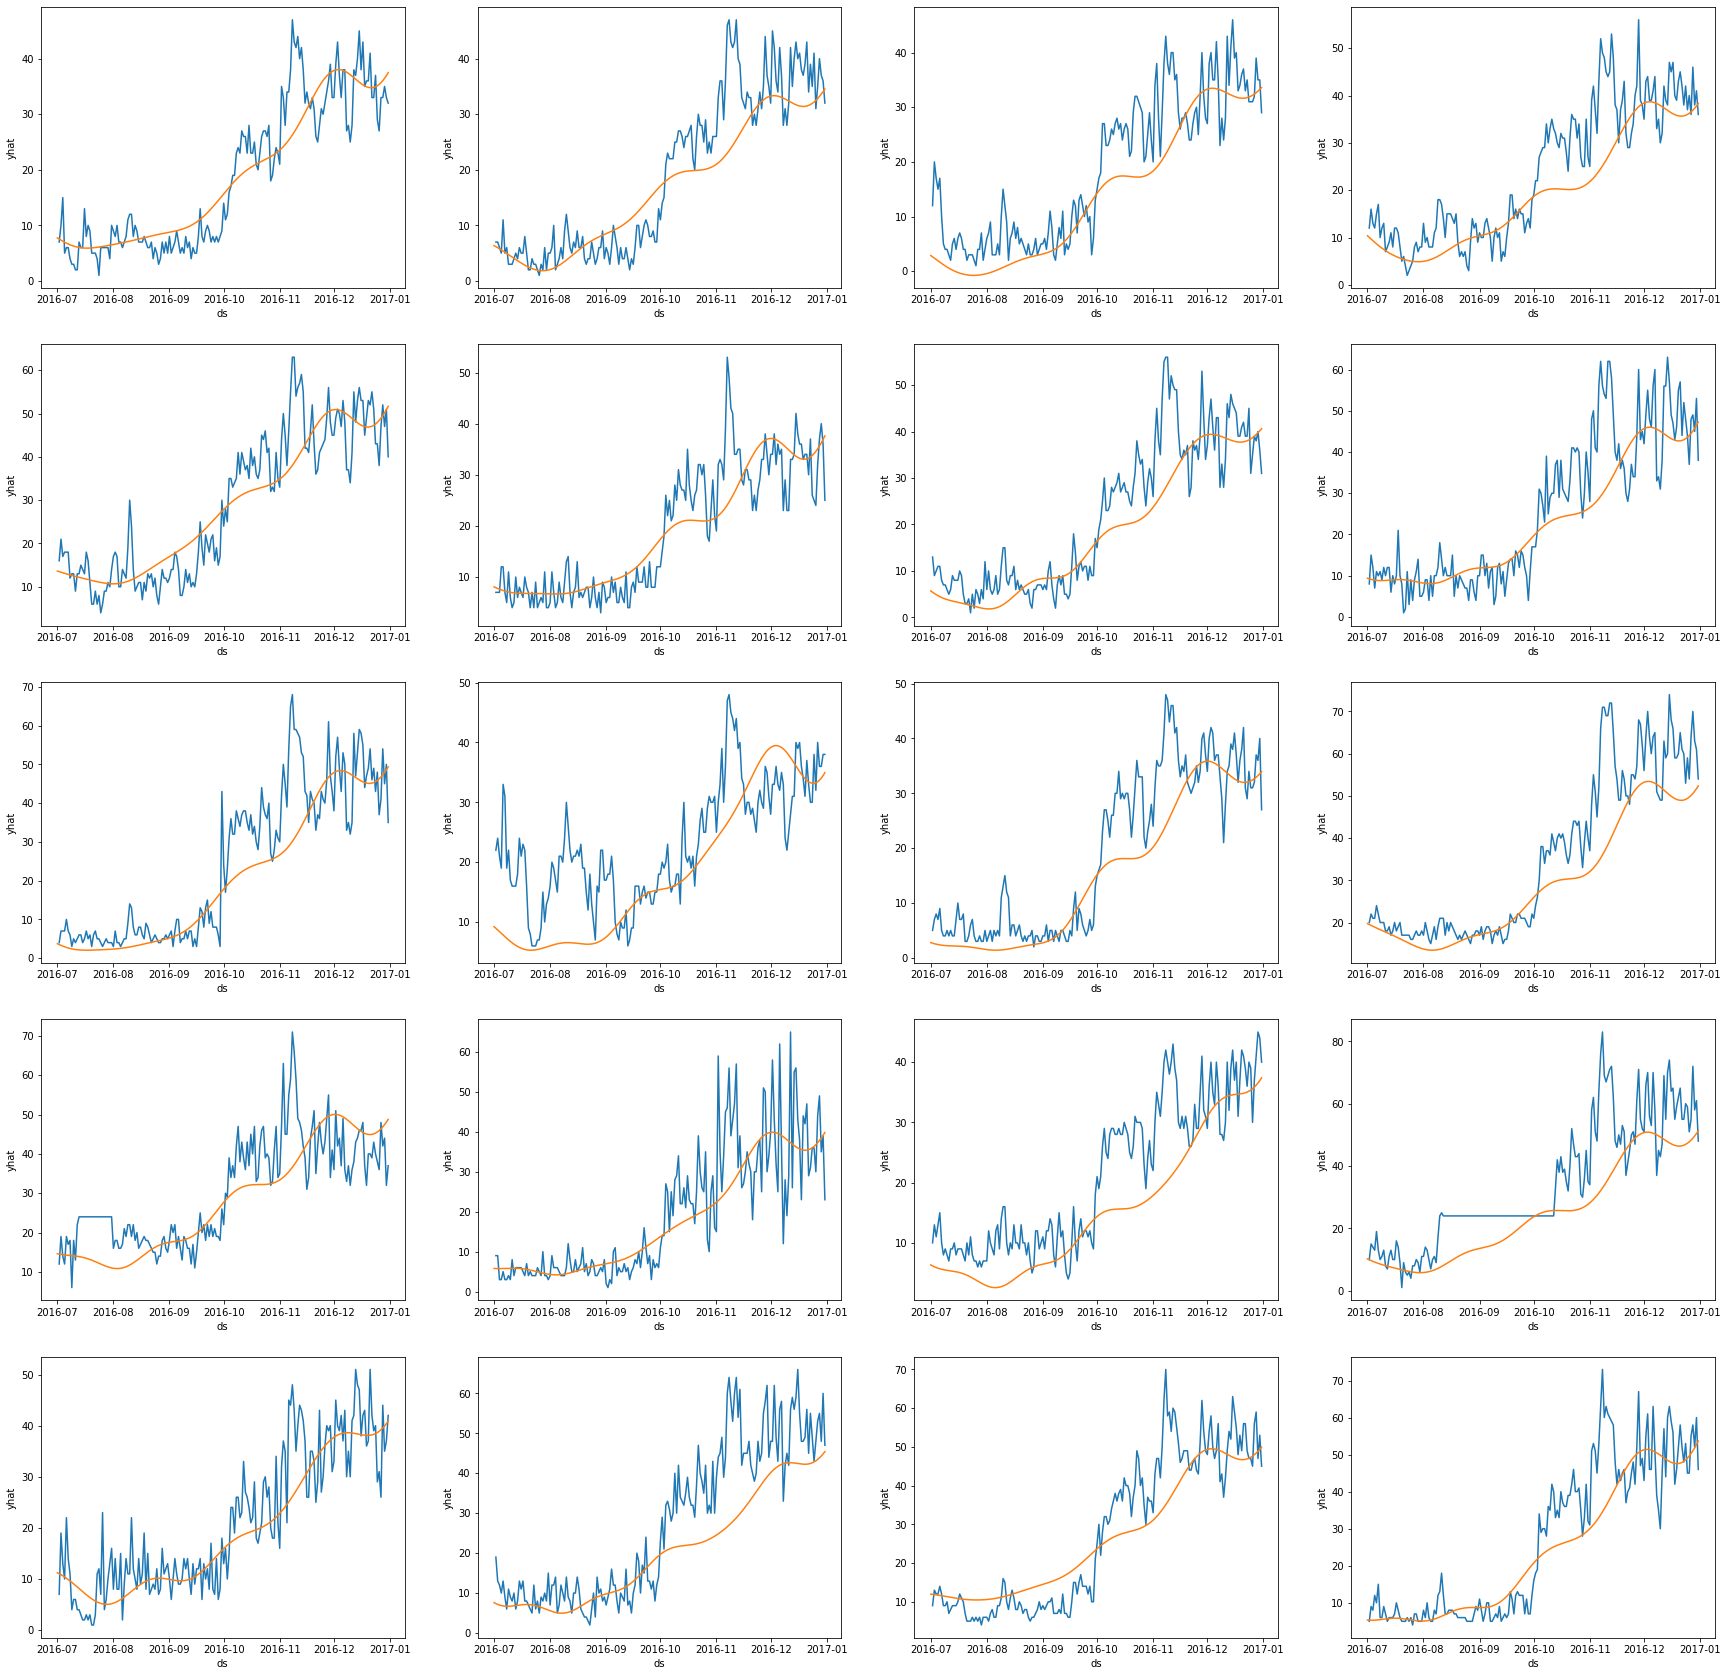

In [476]:
rmsd = []

plt.figure(figsize=(30,30))
for i, df in enumerate(dfs):
    forecast, future, m = train_prophet(df)
    test = divide_into_train_and_test_halfyear(df)[1]
    df['Prophet_regression_halvår'] = forecast.yhat
    rmsd.append(round(mean_squared_error(forecast.yhat[-183:], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(5,4,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=test)
    sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2016-07-01'])
    
results['rmsd_halvår'] = rmsd

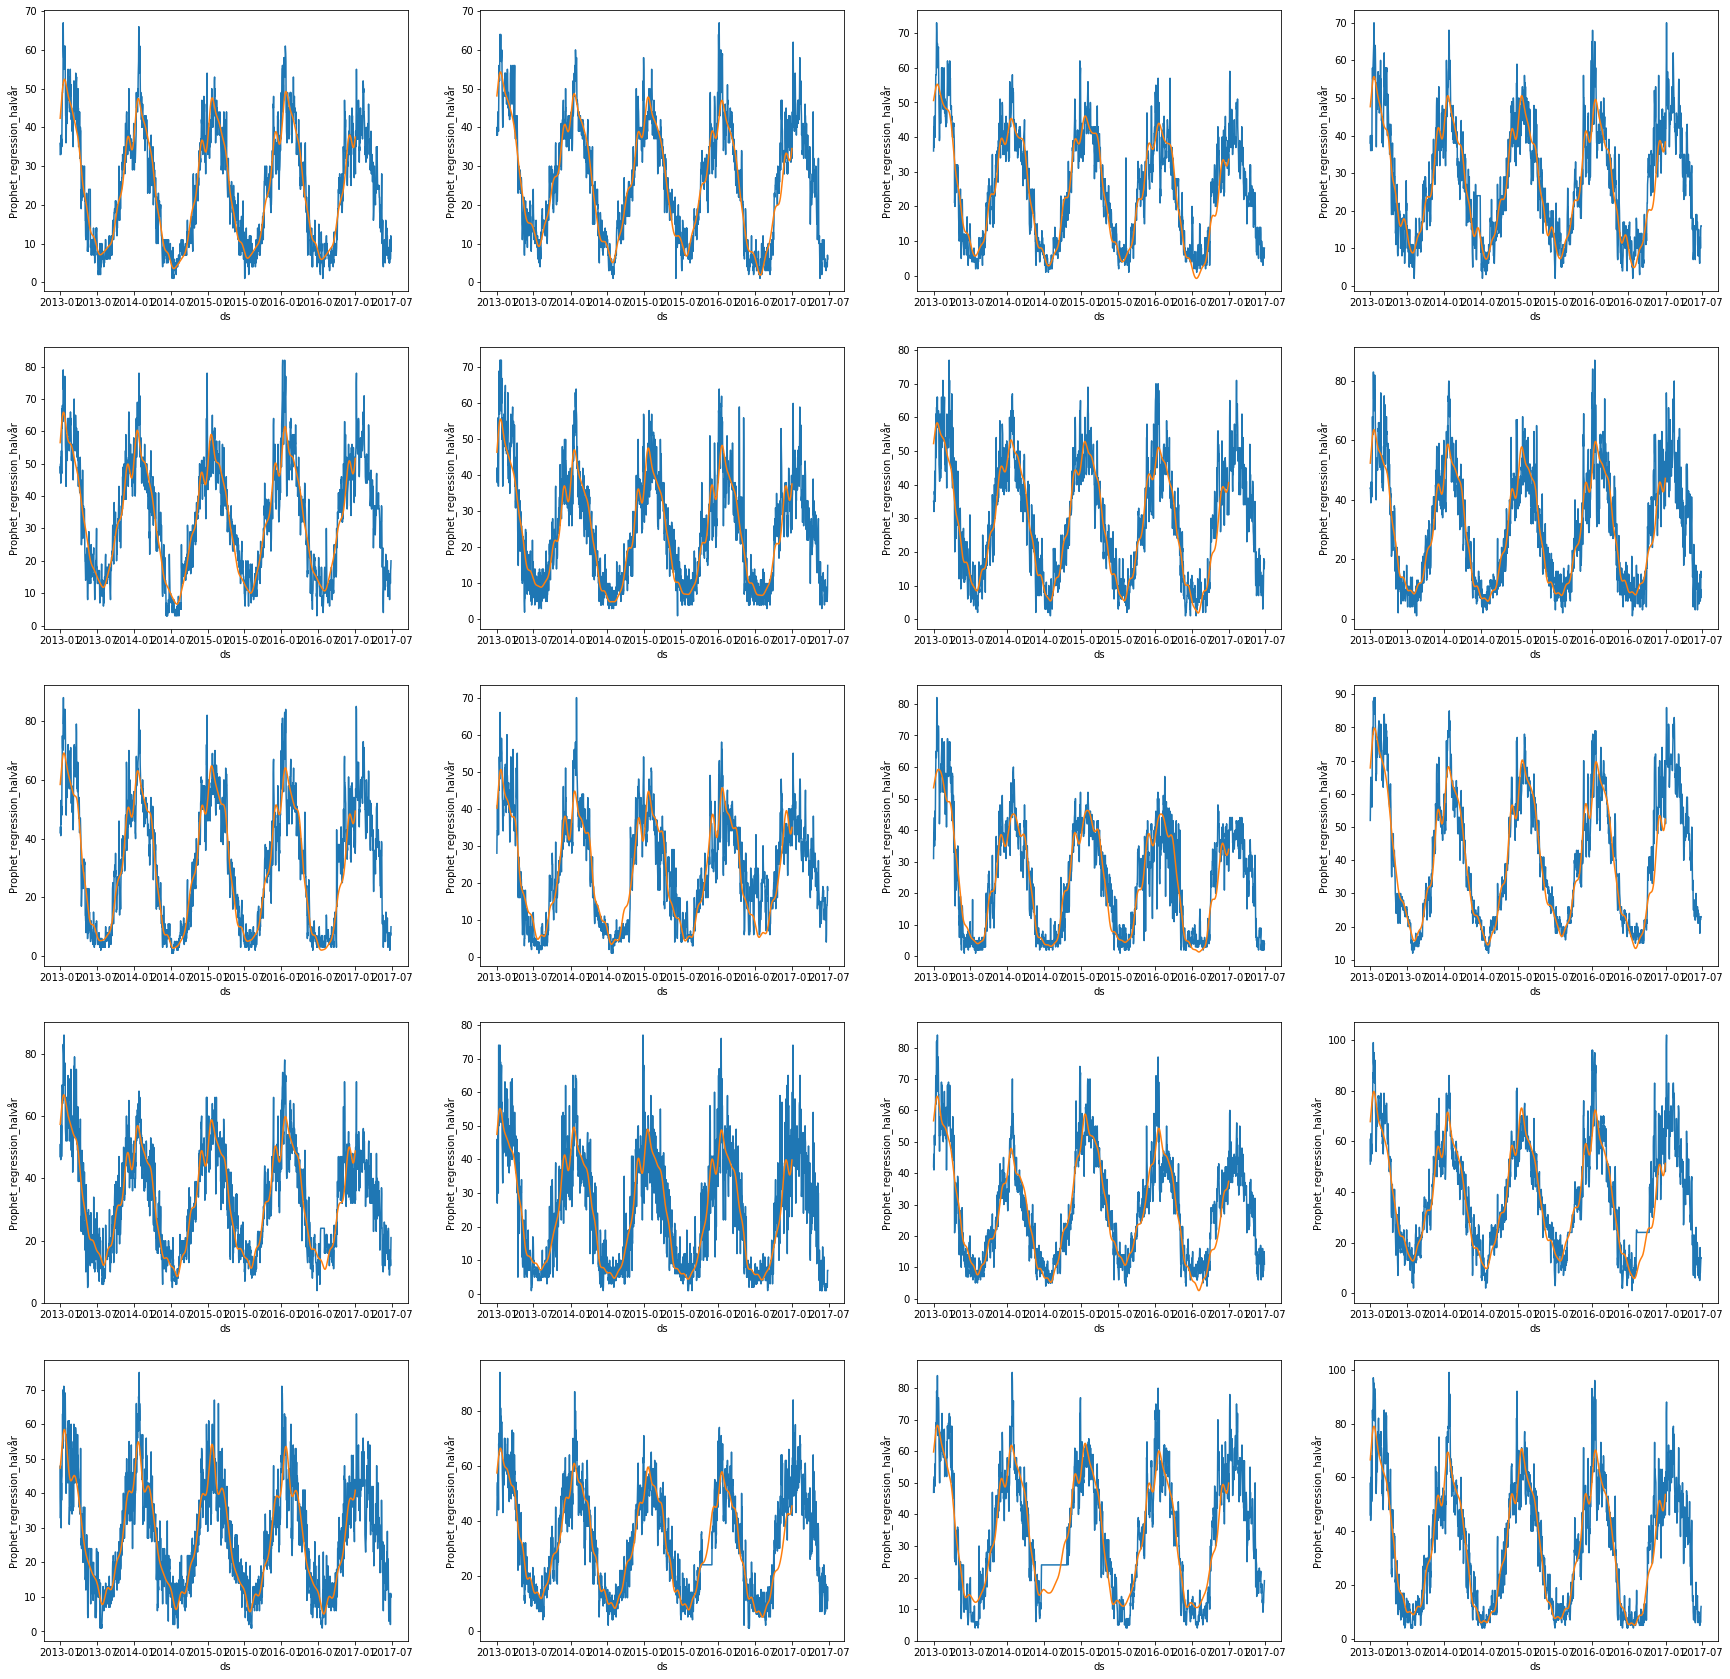

In [477]:
plt.figure(figsize=(30,30))
for i, df in enumerate(dfs):
    plt.subplot(5,4,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=df)
    sns.lineplot(x = 'ds', y = 'Prophet_regression_halvår', data=df)
    #ax = sns.scatterplot(x = 'ds', y = 'K2_Regression', data=df, marker = '.')
    #ax.set_xlim(df.ds.min(), df.ds.max())
    

## Mer väder!

In [519]:
import os

files = os.listdir('data/')
[f for f in files if f.startswith('Helsingborg')]

['HelsingborgA_daggpunkt_h.csv',
 'HelsingborgA_lufttemperatur_dygn.csv',
 'HelsingborgA_Lufttryck_h.csv',
 'HelsingborgA_nederbördsmängd_dygn.csv',
 'HelsingborgA_nederbördstyp_dygn.csv',
 'HelsingborgA_Vind_h.csv']

In [550]:
temp = pd.read_csv('data/HelsingborgA_lufttemperatur_dygn.csv', skiprows=9, sep=';')
temp['Representativt dygn'] = pd.to_datetime(temp['Representativt dygn'])- pd.DateOffset(days=1)
temp = temp[temp['Representativt dygn'] >= '2013-01-01'][['Representativt dygn', 'Lufttemperatur']]
temp.columns = ['Datum', 'Temperatur']
temp.set_index('Datum', inplace=True)
temp

Temperatur
Datum                 
2013-01-01         3.9
2013-01-02         6.4
2013-01-03         6.0
2013-01-04         2.4
2013-01-05         4.4
...                ...
2020-02-24         4.5
2020-02-25         1.3
2020-02-26         0.6
2020-02-27         2.5
2020-02-28         3.9

[2615 rows x 1 columns]

In [523]:
daggpunkt = pd.read_csv('data/HelsingborgA_daggpunkt_h.csv', skiprows=9, sep=';', low_memory=False)
daggpunkt['Datum'] = pd.to_datetime(daggpunkt['Datum'])- pd.DateOffset(days=1)
daggpunkt = daggpunkt[daggpunkt.Datum >= '2013-01-01']
daggpunkt = daggpunkt.groupby('Datum')['Daggpunktstemperatur'].mean()

In [528]:
lufttryck = pd.read_csv('data/HelsingborgA_Lufttryck_h.csv', skiprows=9, sep=';', low_memory=False) 
lufttryck['Datum'] = pd.to_datetime(lufttryck['Datum'])- pd.DateOffset(days=1)
lufttryck = lufttryck[lufttryck.Datum >= '2013-01-01']
lufttryck = lufttryck.groupby('Datum')['Lufttryck reducerat havsytans nivå'].mean()
lufttryck = lufttryck.rename('Lufttryck')

In [544]:
vind = pd.read_csv('data/HelsingborgA_Vind_h.csv', skiprows=9, sep=';', low_memory=False)
vind['Datum'] = pd.to_datetime(vind['Datum']) - pd.DateOffset(days=1)
vind = vind[vind.Datum >= '2013-01-01']
vind = vind.groupby('Datum')[['Vindriktning', 'Vindhastighet']].mean()
vind

Vindriktning  Vindhastighet
Datum                                  
2013-01-01    249.125000       3.525000
2013-01-02    266.458333       7.191667
2013-01-03    301.916667       5.833333
2013-01-04    144.958333       1.141667
2013-01-05    196.916667       1.833333
...                  ...            ...
2020-02-25    267.833333       3.304167
2020-02-26    110.833333       0.879167
2020-02-27    217.291667       2.758333
2020-02-28    151.833333       3.700000
2020-02-29    205.571429       5.614286

[2613 rows x 2 columns]

In [546]:
nb_mängd = pd.read_csv('data/HelsingborgA_nederbördsmängd_dygn.csv', skiprows=9, sep=';', low_memory=False)
nb_mängd['Representativt dygn'] = pd.to_datetime(nb_mängd['Representativt dygn'])- pd.DateOffset(days=1)
nb_mängd = nb_mängd[nb_mängd['Representativt dygn'] >= '2013-01-01'][['Representativt dygn', 'Nederbördsmängd']]
nb_mängd.columns = ['Datum', 'Nederbördsmängd']
nb_mängd.set_index('Datum', inplace=True)
nb_mängd

Nederbördsmängd
Datum                      
2013-01-01              7.6
2013-01-02              0.0
2013-01-03              0.4
2013-01-04              1.2
2013-01-05              1.9
...                     ...
2020-02-24              8.3
2020-02-25              0.1
2020-02-26              0.1
2020-02-27              1.7
2020-02-28              3.8

[2615 rows x 1 columns]

In [552]:
weather = temp.join(nb_mängd).join(vind).join(lufttryck).join(daggpunkt)
weather.head()

Temperatur  Nederbördsmängd  Vindriktning  Vindhastighet  \
Datum                                                                  
2013-01-01         3.9              7.6    249.125000       3.525000   
2013-01-02         6.4              0.0    266.458333       7.191667   
2013-01-03         6.0              0.4    301.916667       5.833333   
2013-01-04         2.4              1.2    144.958333       1.141667   
2013-01-05         4.4              1.9    196.916667       1.833333   

              Lufttryck  Daggpunktstemperatur  
Datum                                          
2013-01-01  1009.579167              2.520833  
2013-01-02  1012.695833              4.620833  
2013-01-03  1018.775000              4.420833  
2013-01-04  1026.116667              2.158333  
2013-01-05  1022.154167              3.762500

In [559]:
weather.isna().sum()

Temperatur              0
Nederbördsmängd         0
Vindriktning            3
Vindhastighet           3
Lufttryck               0
Daggpunktstemperatur    7
dtype: int64

In [560]:
weather = weather.interpolate(method='linear')
weather.isna().sum()

Temperatur              0
Nederbördsmängd         0
Vindriktning            0
Vindhastighet           0
Lufttryck               0
Daggpunktstemperatur    0
dtype: int64

In [561]:
dfs_weather = [df_selected2[df_selected2.columns[i]] for i in range(20)]
dfs_weather = [prepare_for_prophet(df) for df in dfs_weather]
dfs_weather = [df.merge(weather, left_on='ds', right_on='Datum', how='left') for df in dfs_weather]
dfs_weather[0]

ds     y  Temperatur  Nederbördsmängd  Vindriktning  \
0    2013-01-01  33.0         3.9              7.6    249.125000   
1    2013-01-02  36.0         6.4              0.0    266.458333   
2    2013-01-03  35.0         6.0              0.4    301.916667   
3    2013-01-04  33.0         2.4              1.2    144.958333   
4    2013-01-05  35.0         4.4              1.9    196.916667   
...         ...   ...         ...              ...           ...   
1633 2017-06-22   9.0        16.6              5.5    169.083333   
1634 2017-06-23   6.0        15.5              4.0    246.750000   
1635 2017-06-24   7.0        15.3              3.0    238.416667   
1636 2017-06-25  12.0        14.4              0.0    264.625000   
1637 2017-06-26   8.0        14.9              0.0    227.291667   

      Vindhastighet    Lufttryck  Daggpunktstemperatur  
0          3.525000  1009.579167              2.520833  
1          7.191667  1012.695833              4.620833  
2          5.833333  1018.775000              4.420833  
3          1.141667  1026.116667              2.158333  
4          1.833333  1022.154167              3.762500  
...             ...          ...                   ...  
1633       2.562500  1005.937500             13.991667  
1634       4.058333  1005.070833             12.008333  
1635       5.500000  1003.145833              8.937500  
1636       5.720833  1005.208333              7.087500  
1637       2.729167  1010.683333              6.687500  

[1638 rows x 8 columns]

In [555]:
dfs_weather[0].columns

Index(['ds', 'y', 'Temperatur', 'Nederbördsmängd', 'Vindriktning',
       'Vindhastighet', 'Lufttryck', 'Daggpunktstemperatur'],
      dtype='object')

In [556]:
results

rmsd  rmsd_temp  rmsd_K2  rmsd_temp_halvår  rmsd_K2_halvår  rmsd_K2_2014
0    7.43       4.14     4.72              4.46            5.06          4.76
1    9.22       4.78     4.80              5.04            6.40          5.17
2   11.96       6.26     5.10              4.74            6.00          5.61
3    7.39       4.94     4.95              5.16            5.48          5.39
4   11.37       5.10     5.40              5.26            5.38          5.54
5   14.10      10.51     6.43              4.64            4.74          6.57
6    8.35       5.24     5.55              4.62            6.31          6.07
7   11.23       6.83     6.30              6.22            6.58          6.43
8   12.12       6.93     5.83              6.57            6.94          6.06
9    9.08       6.25     5.84              8.56            9.91          7.51
10  16.20      10.52     6.94              4.95            5.32          6.99
11  11.23       5.94     5.78              7.52            7.26          5.85
12   9.31       5.32     5.74              7.30            7.05          5.86
13   8.82       9.38     6.26              7.17            7.35          6.61
14  18.77      13.39     5.33              5.80            5.82          5.80
15  14.17       6.77     7.12              9.78            9.00          7.49
16   7.86       6.62     6.12              5.42            7.96          6.93
17  13.09       7.65     7.60              7.10            6.87          8.18
18   8.67       7.59     6.11              6.76           10.50          9.27
19  10.09       6.76     6.21              6.19            7.88          6.71

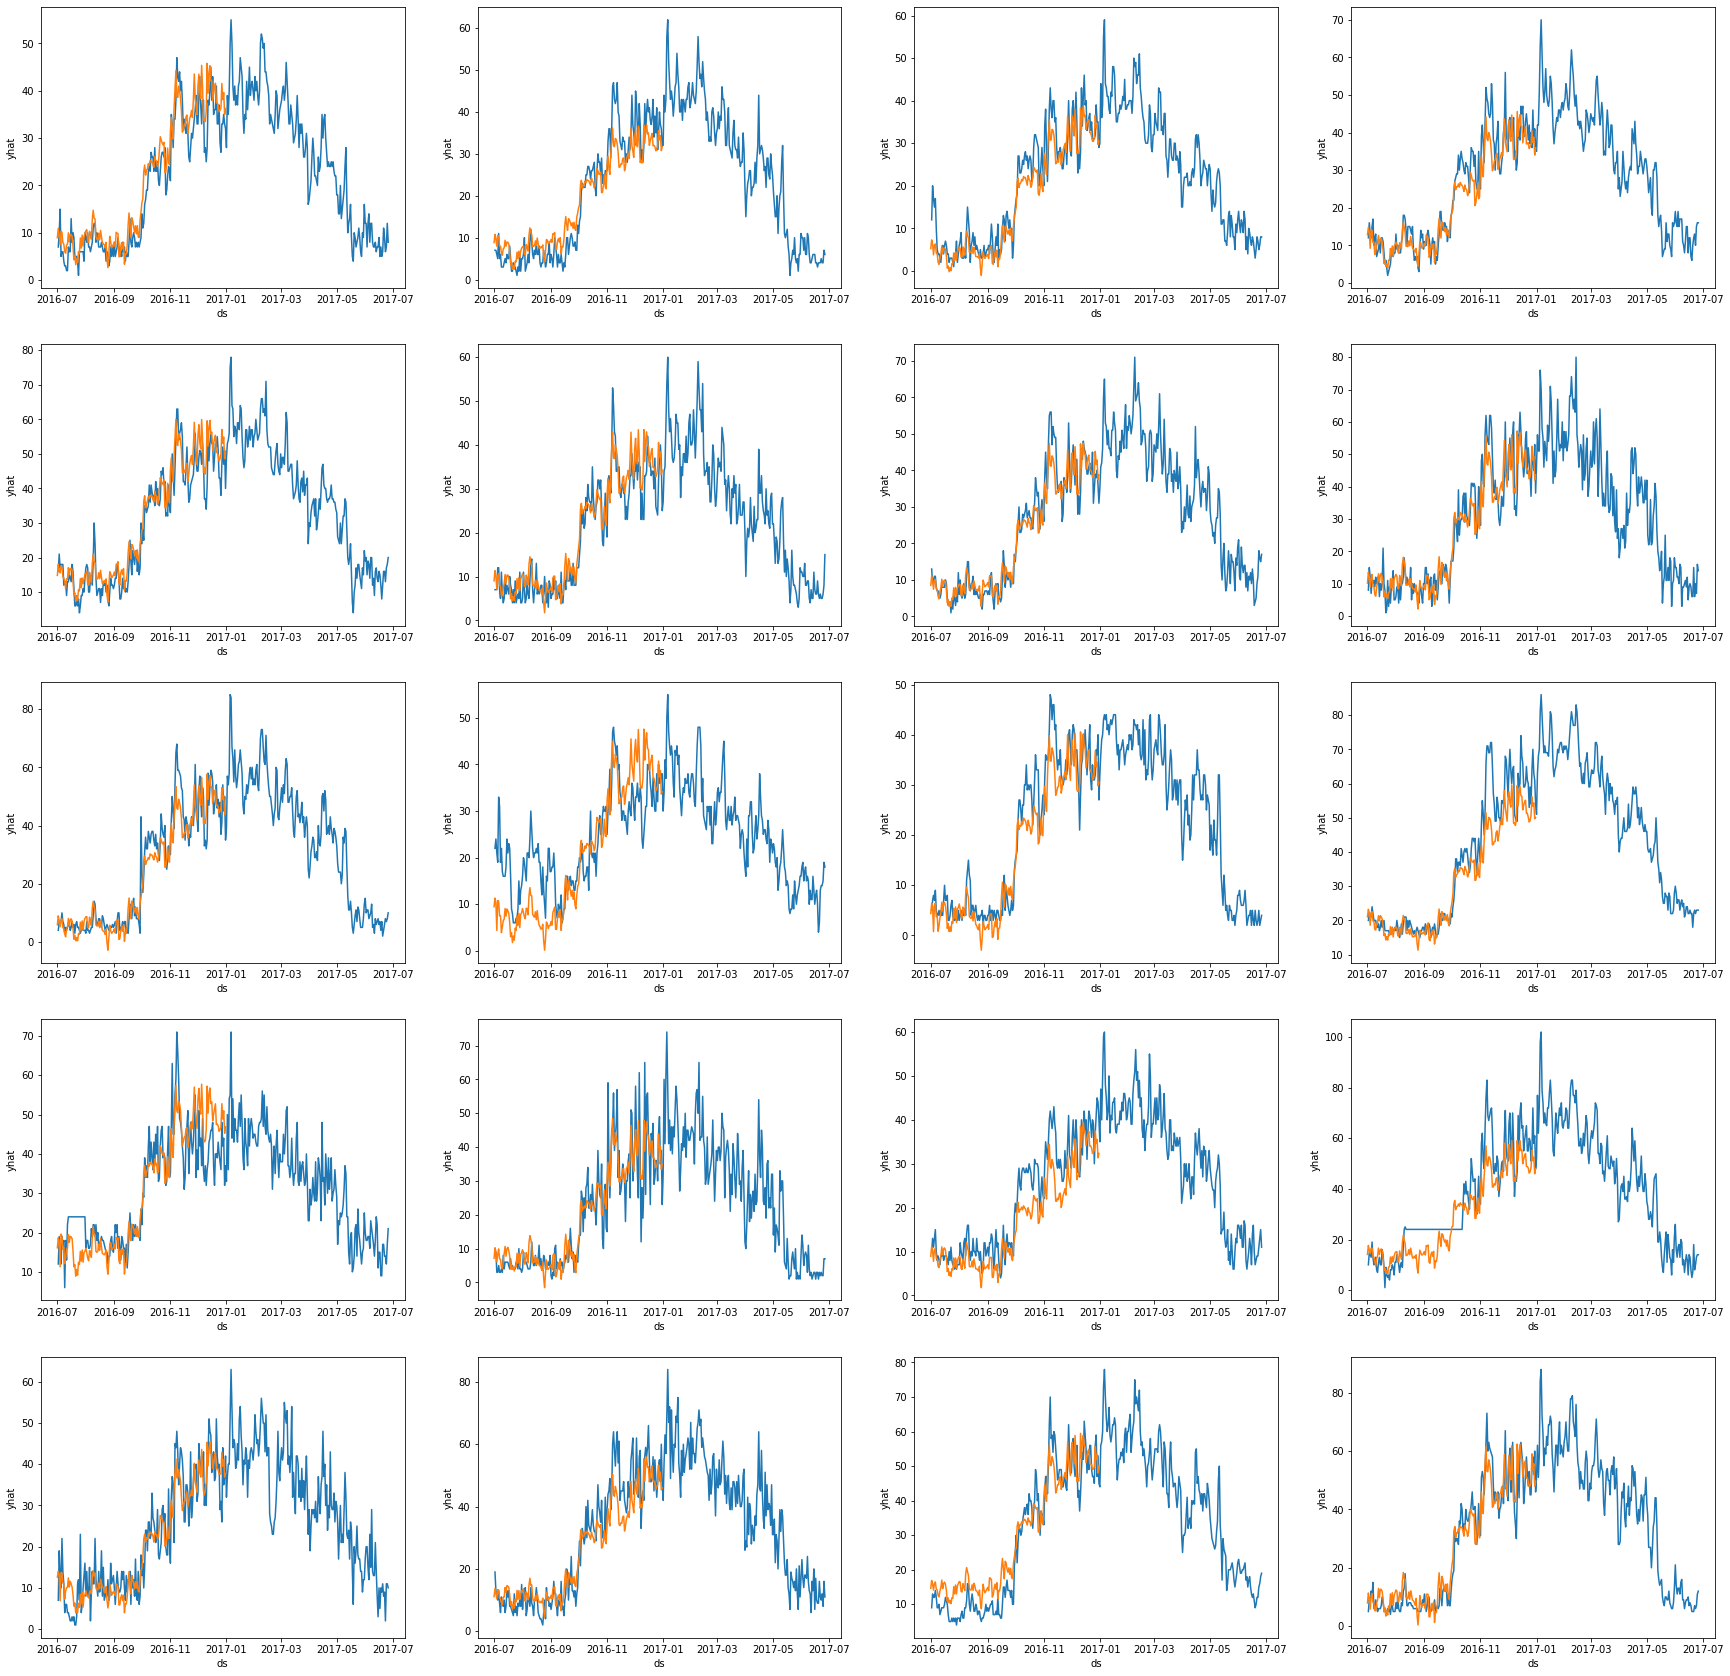

In [565]:
rmsd = []
var_list = ['Temperatur', 'Nederbördsmängd', 'Vindriktning', 'Vindhastighet', 'Lufttryck', 'Daggpunktstemperatur']

plt.figure(figsize=(30,30))
for i, df in enumerate(dfs_weather):
    forecast, future, m = train_prophet(df, periods=183, regressor_list=var_list)
    test = divide_into_train_and_test_halfyear(df)[1]
    df['Prophet_regression_halvår_all_väder'] = forecast.yhat
    rmsd.append(round(mean_squared_error(forecast.yhat[-183:], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(5,4,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=df[df.ds>'2016-07-01'])
    sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2016-07-01'])
    
results['rmsd_halvår_all_väder'] = rmsd

In [567]:
for v in var_list:
    print(v)
    rmsd = []
    for i, df in enumerate(dfs_weather):
        forecast, future, m = train_prophet(df, periods=183, regressor_list=[v2 for v2 in var_list if v2!=v])
        test = divide_into_train_and_test_halfyear(df)[1]
        df['Prophet_regression_halvår_all_väder_exkl'+v] = forecast.yhat
        rmsd.append(round(mean_squared_error(forecast.yhat[-183:], test.y, squared=False), 2))
    results['rmsd_halvår_all_väder_exkl'+v] = rmsd

Temperatur
Nederbördsmängd
Vindriktning
Vindhastighet
Lufttryck
Daggpunktstemperatur


In [573]:
results = results.reset_index()
results['index'] = results['index']+1

In [595]:
results

index   rmsd  rmsd_temp  rmsd_K2  rmsd_temp_halvår  rmsd_K2_halvår  \
0       1   7.43       4.14     4.72              4.46            5.06   
1       2   9.22       4.78     4.80              5.04            6.40   
2       3  11.96       6.26     5.10              4.74            6.00   
3       4   7.39       4.94     4.95              5.16            5.48   
4       5  11.37       5.10     5.40              5.26            5.38   
5       6  14.10      10.51     6.43              4.64            4.74   
6       7   8.35       5.24     5.55              4.62            6.31   
7       8  11.23       6.83     6.30              6.22            6.58   
8       9  12.12       6.93     5.83              6.57            6.94   
9      10   9.08       6.25     5.84              8.56            9.91   
10     11  16.20      10.52     6.94              4.95            5.32   
11     12  11.23       5.94     5.78              7.52            7.26   
12     13   9.31       5.32     5.74              7.30            7.05   
13     14   8.82       9.38     6.26              7.17            7.35   
14     15  18.77      13.39     5.33              5.80            5.82   
15     16  14.17       6.77     7.12              9.78            9.00   
16     17   7.86       6.62     6.12              5.42            7.96   
17     18  13.09       7.65     7.60              7.10            6.87   
18     19   8.67       7.59     6.11              6.76           10.50   
19     20  10.09       6.76     6.21              6.19            7.88   

    rmsd_K2_2014  rmsd_halvår_all_väder  rmsd_halvår_all_väder_exklTemperatur  \
0           4.76                   4.40                                  4.01   
1           5.17                   5.03                                  5.43   
2           5.61                   4.69                                  5.44   
3           5.39                   5.20                                  6.05   
4           5.54                   5.32                                  5.69   
5           6.57                   4.52                                  4.69   
6           6.07                   4.55                                  5.23   
7           6.43                   6.08                                  6.62   
8           6.06                   6.39                                  7.19   
9           7.51                   8.77                                  9.07   
10          6.99                   4.96                                  5.70   
11          5.85                   7.34                                  8.16   
12          5.86                   7.27                                  7.65   
13          6.61                   6.90                                  7.13   
14          5.80                   5.91                                  6.58   
15          7.49                   9.64                                 11.10   
16          6.93                   5.41                                  5.60   
17          8.18                   7.00                                  8.59   
18          9.27                   6.54                                  6.65   
19          6.71                   6.01                                  6.56   

    rmsd_halvår_all_väder_exklNederbördsmängd  \
0                                        4.41   
1                                        5.04   
2                                        4.64   
3                                        5.14   
4                                        5.30   
5                                        4.50   
6                                        4.52   
7                                        6.04   
8                                        6.38   
9                                        8.71   
10                                       4.87   
11                                       7.31   
12                                       7.29   
13                                       6.92   
14          

In [596]:
results_norm = results.copy(deep=True)

In [601]:
results_norm = results_norm[['rmsd_K2_2014', 
         'rmsd_temp_halvår',
         'rmsd_halvår_all_väder',
         'rmsd_halvår_all_väder_exklTemperatur',
         'rmsd_halvår_all_väder_exklNederbördsmängd',
         'rmsd_halvår_all_väder_exklVindriktning',
         'rmsd_halvår_all_väder_exklVindhastighet',
         'rmsd_halvår_all_väder_exklLufttryck',
         'rmsd_halvår_all_väder_exklDaggpunktstemperatur']].sub(results_norm['rmsd_halvår_all_väder'], axis=0)

results_norm = results_norm.reset_index()
results_norm['index'] = results_norm['index']+1

In [602]:
results_melt = results_norm[['index',
         'rmsd_K2_2014', 
         'rmsd_temp_halvår',
         'rmsd_halvår_all_väder',
         'rmsd_halvår_all_väder_exklTemperatur',
         'rmsd_halvår_all_väder_exklNederbördsmängd',
         'rmsd_halvår_all_väder_exklVindriktning',
         'rmsd_halvår_all_väder_exklVindhastighet',
         'rmsd_halvår_all_väder_exklLufttryck',
         'rmsd_halvår_all_väder_exklDaggpunktstemperatur']].melt(id_vars=['index'], value_vars=['rmsd_K2_2014', 
         'rmsd_temp_halvår',
         'rmsd_halvår_all_väder',
         'rmsd_halvår_all_väder_exklTemperatur',
         'rmsd_halvår_all_väder_exklNederbördsmängd',
         'rmsd_halvår_all_väder_exklVindriktning',
         'rmsd_halvår_all_väder_exklVindhastighet',
         'rmsd_halvår_all_väder_exklLufttryck',
         'rmsd_halvår_all_väder_exklDaggpunktstemperatur'])


In [603]:
results_melt

index                                        variable  value
0        1                                    rmsd_K2_2014   0.36
1        2                                    rmsd_K2_2014   0.14
2        3                                    rmsd_K2_2014   0.92
3        4                                    rmsd_K2_2014   0.19
4        5                                    rmsd_K2_2014   0.22
..     ...                                             ...    ...
175     16  rmsd_halvår_all_väder_exklDaggpunktstemperatur  -0.17
176     17  rmsd_halvår_all_väder_exklDaggpunktstemperatur  -0.01
177     18  rmsd_halvår_all_väder_exklDaggpunktstemperatur   0.07
178     19  rmsd_halvår_all_väder_exklDaggpunktstemperatur  -0.03
179     20  rmsd_halvår_all_väder_exklDaggpunktstemperatur   0.00

[180 rows x 3 columns]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

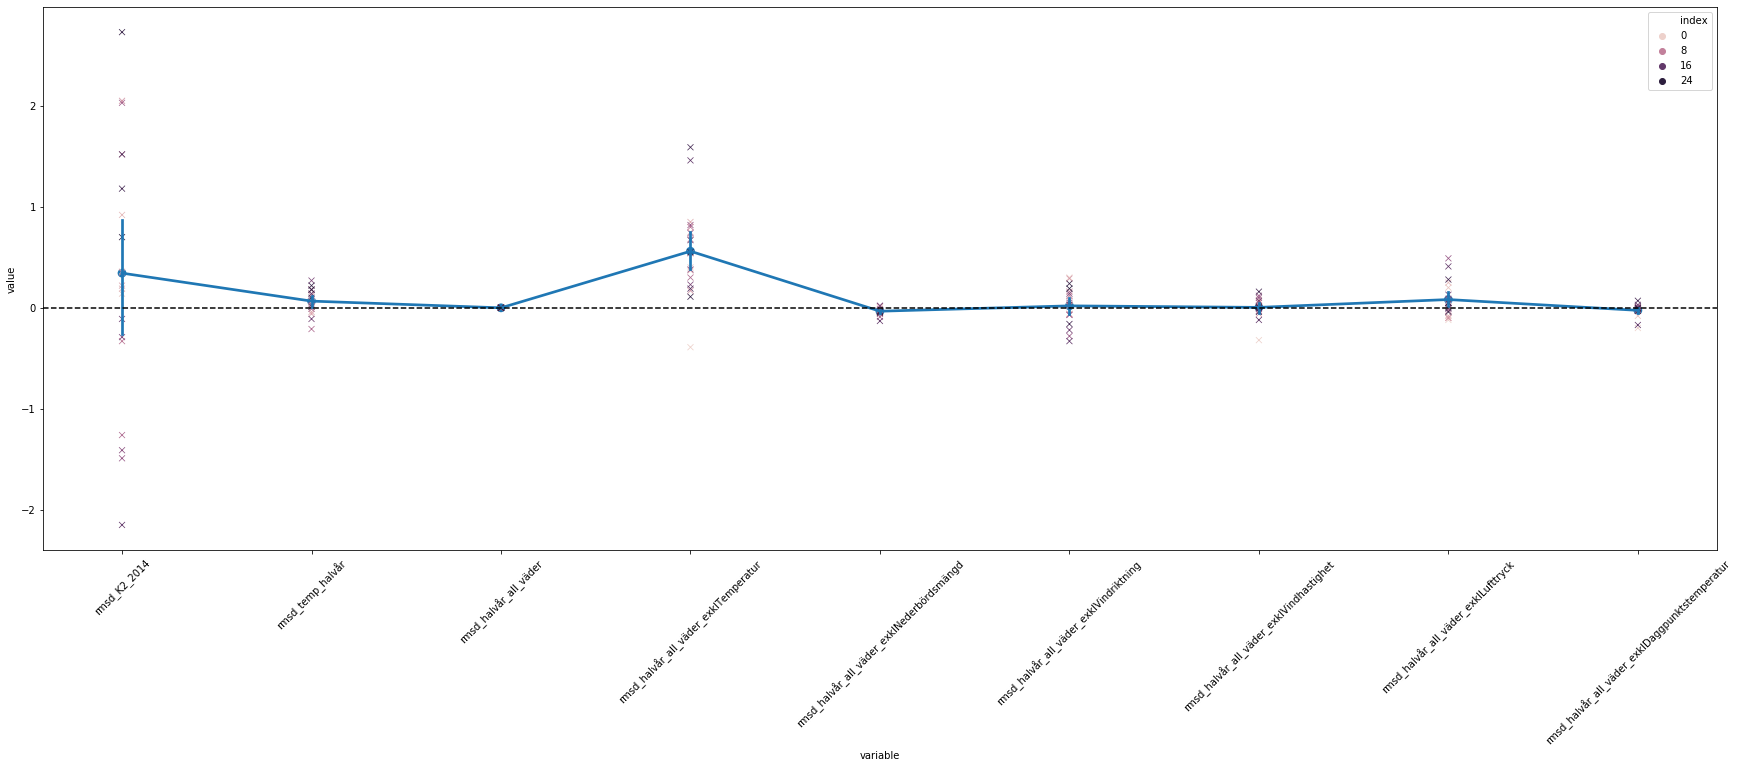

In [607]:
plt.figure(figsize=(30,10))
sns.pointplot(y='value', x='variable', data=results_melt)
ax = sns.scatterplot(y='value', x='variable', hue= 'index', data=results_melt, marker = 'x', color='orange')
ax.axhline(0, ls='--', c = 'k')
plt.xticks(rotation=45)


Prophet med alla vädervariabler utom temperatur är den enda som tydligt presterar sämre jämfört med prophet + alla tillgängliga vädervariabler. Dock kan man se att modellen med endast temperatur presterar något sämre än då alla vädervariabler inkluderas för majoriteten av mätstationer. Exkludera lufttryck ser ut att prestera sämre. Kanske testa en sista modell med Temperatur och lufttryck som extra regressors.

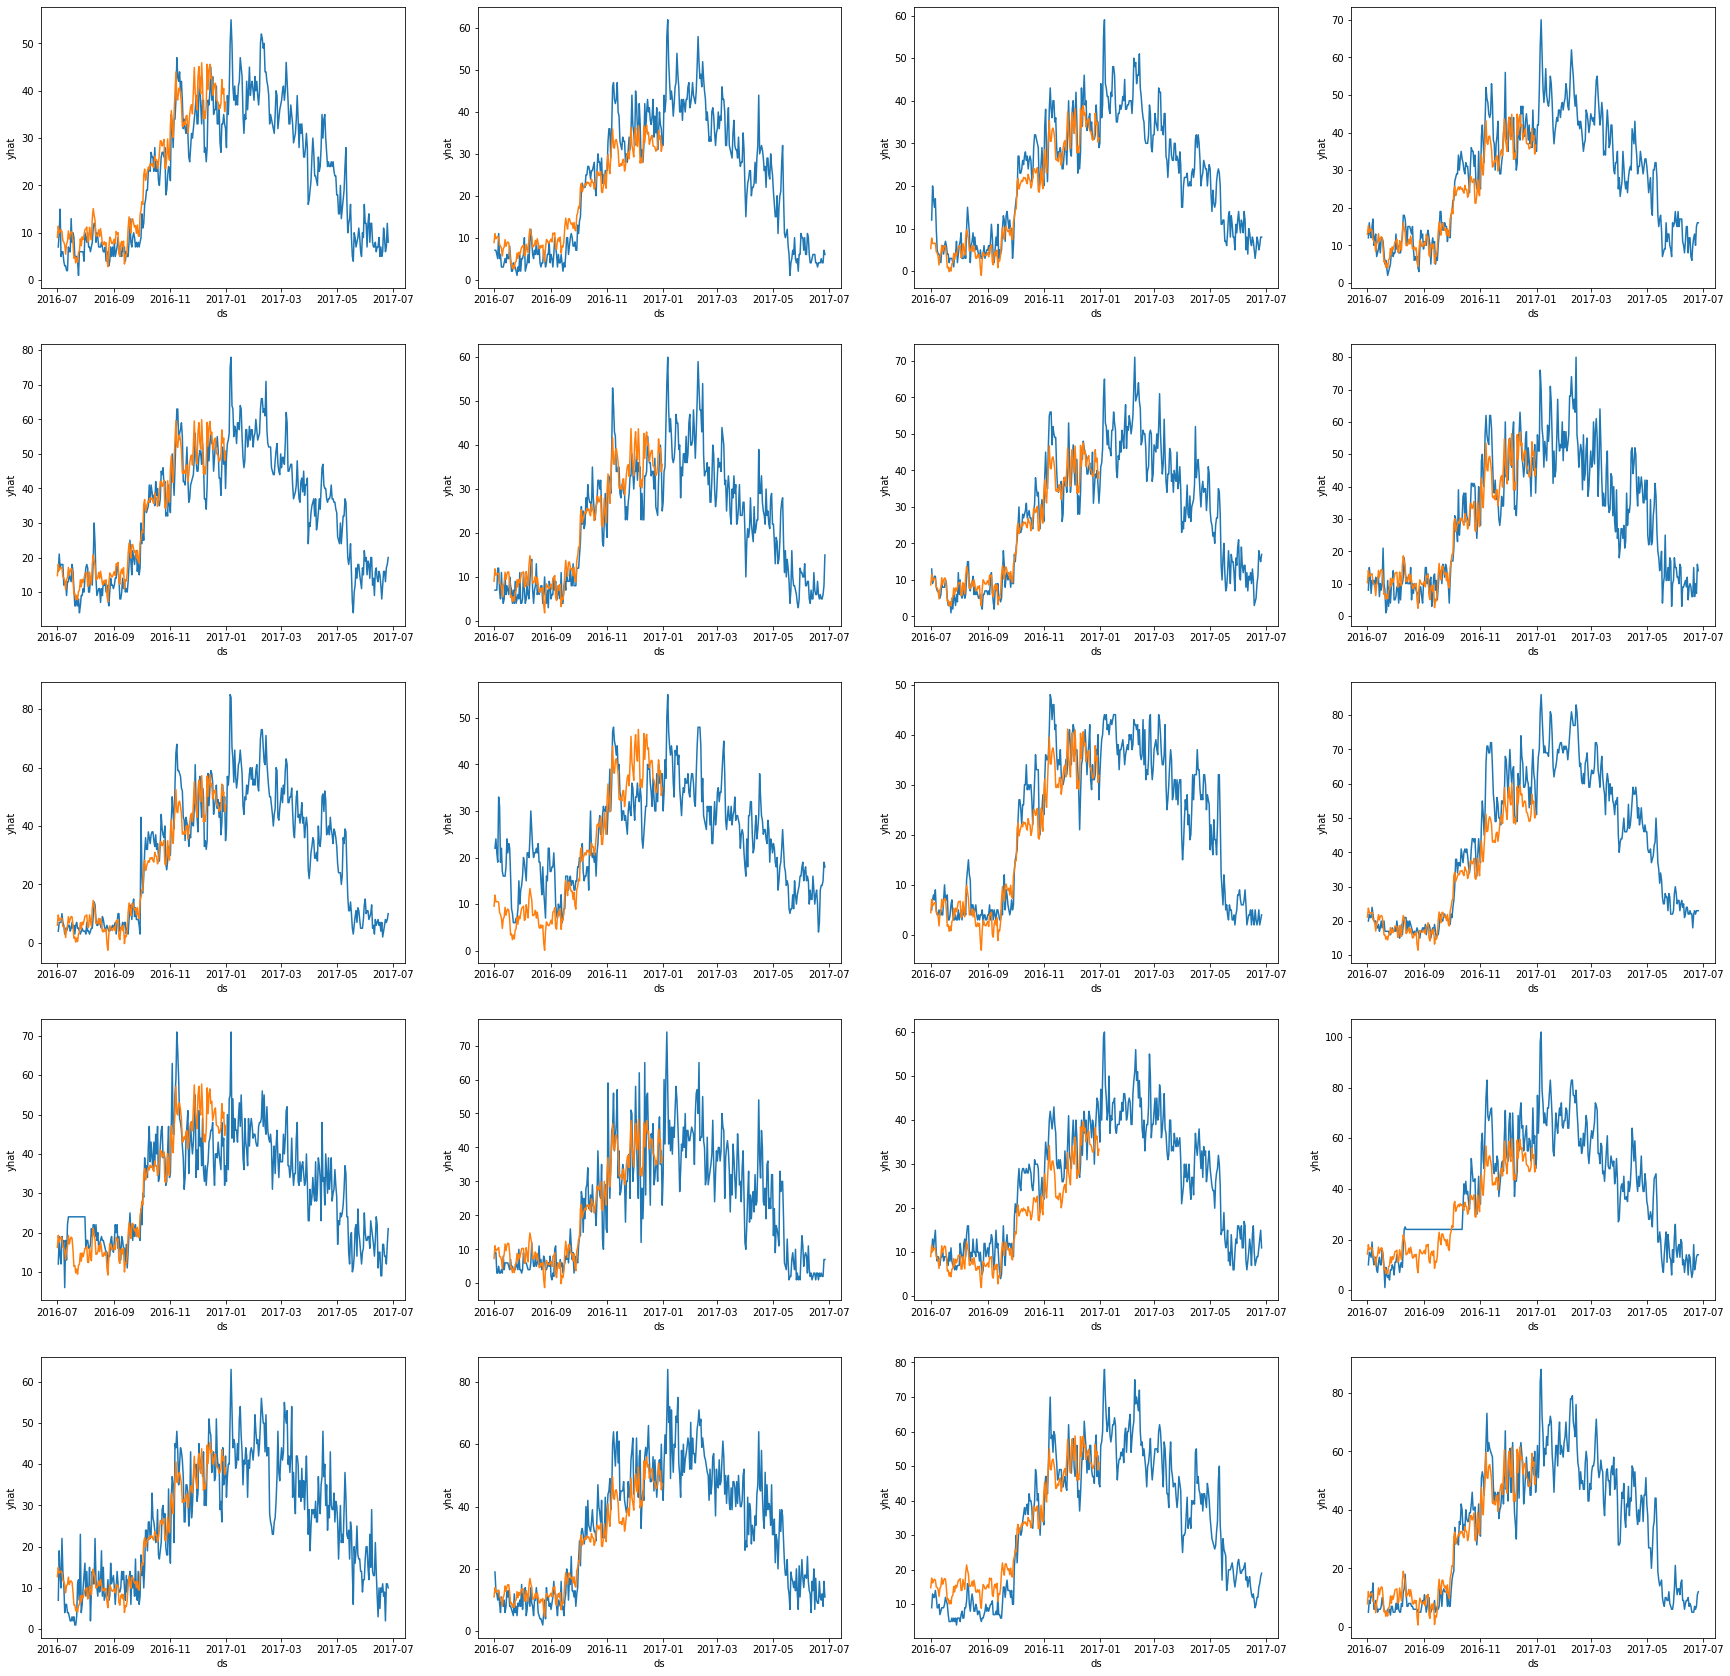

In [608]:
rmsd = []
reg_list = ['Temperatur', 'Lufttryck']

plt.figure(figsize=(30,30))
for i, df in enumerate(dfs_weather):
    forecast, future, m = train_prophet(df, periods=183, regressor_list=reg_list)
    test = divide_into_train_and_test_halfyear(df)[1]
    df['Prophet_regression_halvår_temp_lufttryck'] = forecast.yhat
    rmsd.append(round(mean_squared_error(forecast.yhat[-183:], test.y, squared=False), 2))
    #print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(5,4,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=df[df.ds>'2016-07-01'])
    sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2016-07-01'])
    
results['rmsd_halvår_temp_lufttryck'] = rmsd

In [613]:
results_norm = results.copy(deep=True)

results_norm = results_norm[['rmsd_K2_2014', 
         'rmsd_temp_halvår',
         'rmsd_halvår_all_väder',
         'rmsd_halvår_all_väder_exklTemperatur',
         'rmsd_halvår_all_väder_exklNederbördsmängd',
         'rmsd_halvår_all_väder_exklVindriktning',
         'rmsd_halvår_all_väder_exklVindhastighet',
         'rmsd_halvår_all_väder_exklLufttryck',
         'rmsd_halvår_all_väder_exklDaggpunktstemperatur', 'rmsd_halvår_temp_lufttryck']].sub(results_norm['rmsd_halvår_all_väder'], axis=0)

results_norm = results_norm.reset_index()
results_norm['index'] = results_norm['index']+1

results_melt = results_norm[['index',
         'rmsd_K2_2014', 
         'rmsd_temp_halvår',
         'rmsd_halvår_all_väder',
         'rmsd_halvår_all_väder_exklTemperatur',
         'rmsd_halvår_all_väder_exklNederbördsmängd',
         'rmsd_halvår_all_väder_exklVindriktning',
         'rmsd_halvår_all_väder_exklVindhastighet',
         'rmsd_halvår_all_väder_exklLufttryck',
         'rmsd_halvår_all_väder_exklDaggpunktstemperatur',
         'rmsd_halvår_temp_lufttryck']].melt(id_vars=['index'], value_vars=['rmsd_K2_2014', 
         'rmsd_temp_halvår',
         'rmsd_halvår_all_väder',
         'rmsd_halvår_all_väder_exklTemperatur',
         'rmsd_halvår_all_väder_exklNederbördsmängd',
         'rmsd_halvår_all_väder_exklVindriktning',
         'rmsd_halvår_all_väder_exklVindhastighet',
         'rmsd_halvår_all_väder_exklLufttryck',
         'rmsd_halvår_all_väder_exklDaggpunktstemperatur',
         'rmsd_halvår_temp_lufttryck'])


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

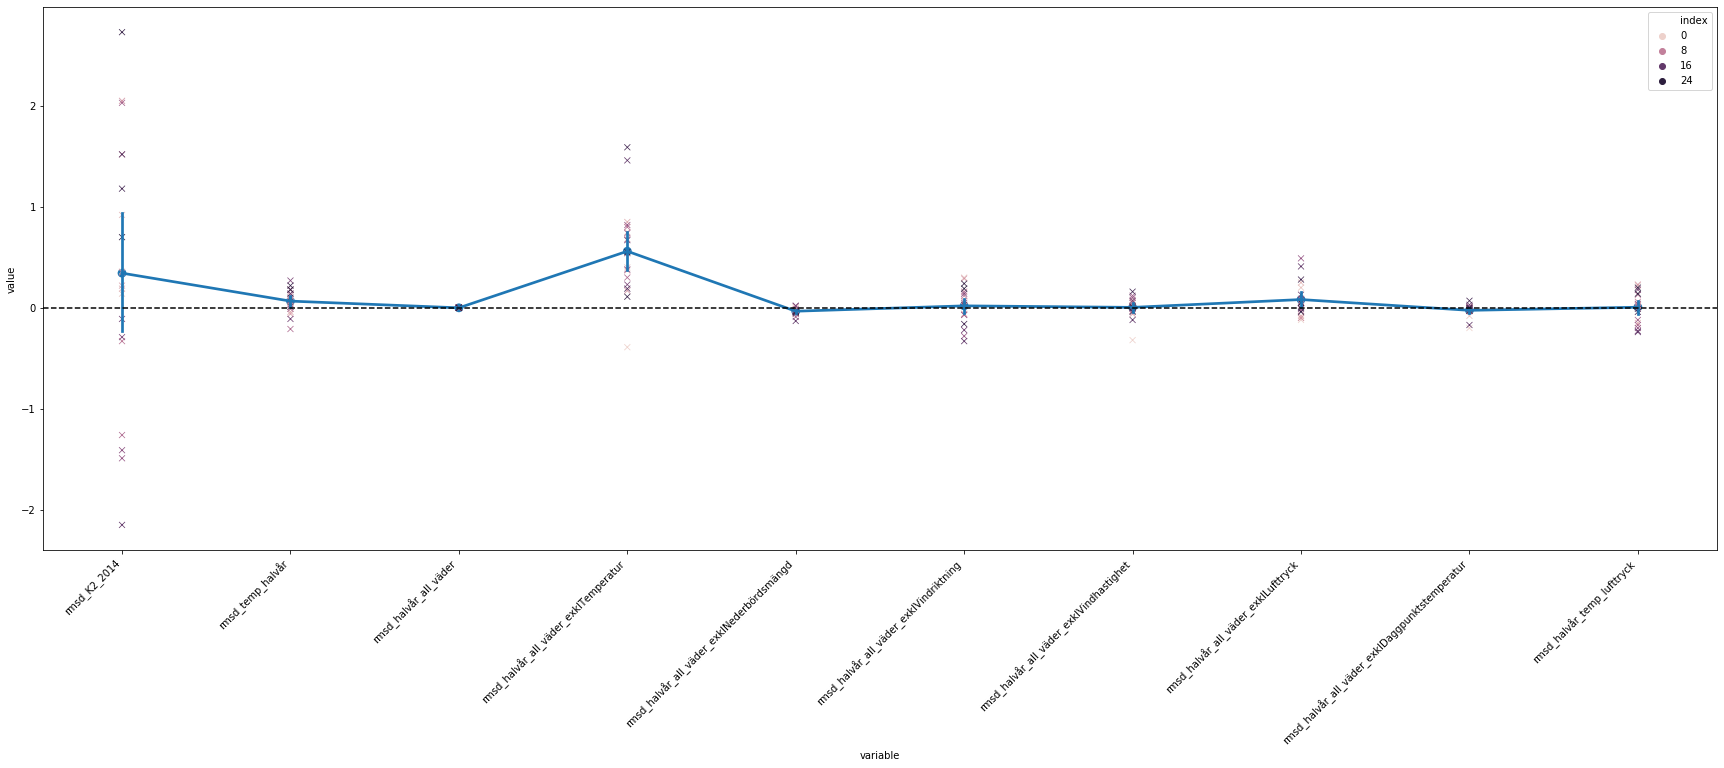

In [622]:
plt.figure(figsize=(30,10))
sns.pointplot(y='value', x='variable', data=results_melt)
ax = sns.scatterplot(y='value', x='variable', hue= 'index', data=results_melt, marker = 'x', color='orange')
ax.axhline(0, ls='--', c = 'k')
plt.xticks(rotation=45, ha="right")


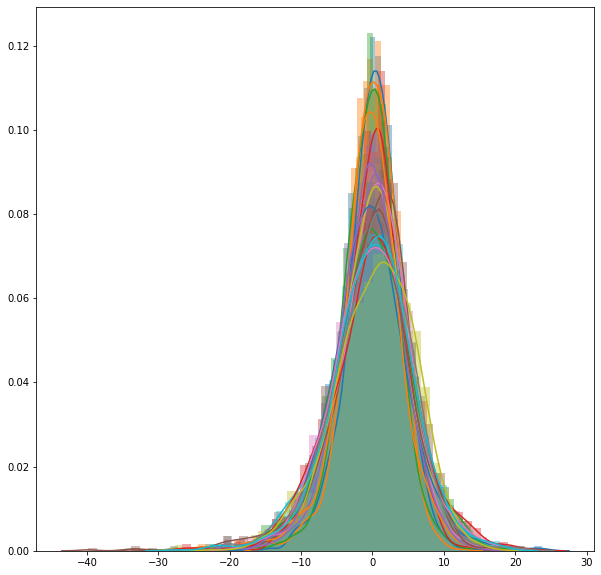

In [620]:
plt.figure(figsize =(10,10))
for i, df in enumerate(dfs_weather):
    #plt.subplot(5,4,i+1)
    sns.distplot(df.Prophet_regression_halvår_all_väder - df.y)

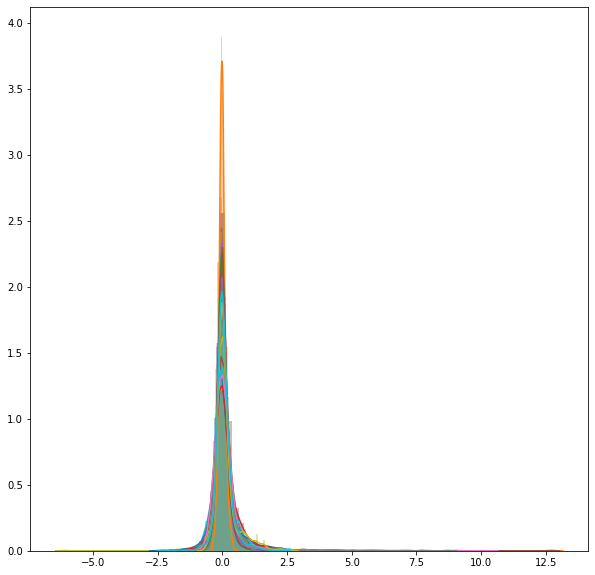

In [621]:
plt.figure(figsize =(10,10))
for i, df in enumerate(dfs_weather):
    #plt.subplot(5,4,i+1)
    sns.distplot((df.Prophet_regression_halvår_all_väder - df.y)/df.y)

In [612]:
results

index   rmsd  rmsd_temp  rmsd_K2  rmsd_temp_halvår  rmsd_K2_halvår  \
0       1   7.43       4.14     4.72              4.46            5.06   
1       2   9.22       4.78     4.80              5.04            6.40   
2       3  11.96       6.26     5.10              4.74            6.00   
3       4   7.39       4.94     4.95              5.16            5.48   
4       5  11.37       5.10     5.40              5.26            5.38   
5       6  14.10      10.51     6.43              4.64            4.74   
6       7   8.35       5.24     5.55              4.62            6.31   
7       8  11.23       6.83     6.30              6.22            6.58   
8       9  12.12       6.93     5.83              6.57            6.94   
9      10   9.08       6.25     5.84              8.56            9.91   
10     11  16.20      10.52     6.94              4.95            5.32   
11     12  11.23       5.94     5.78              7.52            7.26   
12     13   9.31       5.32     5.74              7.30            7.05   
13     14   8.82       9.38     6.26              7.17            7.35   
14     15  18.77      13.39     5.33              5.80            5.82   
15     16  14.17       6.77     7.12              9.78            9.00   
16     17   7.86       6.62     6.12              5.42            7.96   
17     18  13.09       7.65     7.60              7.10            6.87   
18     19   8.67       7.59     6.11              6.76           10.50   
19     20  10.09       6.76     6.21              6.19            7.88   

    rmsd_K2_2014  rmsd_halvår_all_väder  rmsd_halvår_all_väder_exklTemperatur  \
0           4.76                   4.40                                  4.01   
1           5.17                   5.03                                  5.43   
2           5.61                   4.69                                  5.44   
3           5.39                   5.20                                  6.05   
4           5.54                   5.32                                  5.69   
5           6.57                   4.52                                  4.69   
6           6.07                   4.55                                  5.23   
7           6.43                   6.08                                  6.62   
8           6.06                   6.39                                  7.19   
9           7.51                   8.77                                  9.07   
10          6.99                   4.96                                  5.70   
11          5.85                   7.34                                  8.16   
12          5.86                   7.27                                  7.65   
13          6.61                   6.90                                  7.13   
14          5.80                   5.91                                  6.58   
15          7.49                   9.64                                 11.10   
16          6.93                   5.41                                  5.60   
17          8.18                   7.00                                  8.59   
18          9.27                   6.54                                  6.65   
19          6.71                   6.01                                  6.56   

    rmsd_halvår_all_väder_exklNederbördsmängd  \
0                                        4.41   
1                                        5.04   
2                                        4.64   
3                                        5.14   
4                                        5.30   
5                                        4.50   
6                                        4.52   
7                                        6.04   
8                                        6.38   
9                                        8.71   
10                                       4.87   
11                                       7.31   
12                                       7.29   
13                                       6.92   
14          


För tävling skall givet data vara 10 csv filer (exkluderat validerings period) som innehåller
Datum, konsumtion, temperatur och övriga vädervariabler för Helsingborg A som jag hittar, K2 regressionsresultat

